# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. 

Наша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откроем файл с данными и изучим общую информацию. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

In [2]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')

после открытия файла выведем первые 5 строк на экран, чтобы проверить загрузились ли данные и что есть в файле

In [3]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


изучим данные методом info()

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

**first_day_exposition** нужно посмотреть и сделать датой 
**is_apartment** - должен быть булев, а у нас object. Нужна проверка

Приведем заголовки **cityCenters_nearest**, **parks_around3000** и **ponds_around3000** к змеиному стилю и нижнему регистру

In [5]:
data.rename(columns = {'cityCenters_nearest':'city_centers_nearest',
                       'parks_around3000':'parks_around_3000',
                       'ponds_around3000':'ponds_around_3000'}, inplace=True)
data.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'city_centers_nearest',
       'parks_around_3000', 'parks_nearest', 'ponds_around_3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

построим гистограммы по всем параметрам

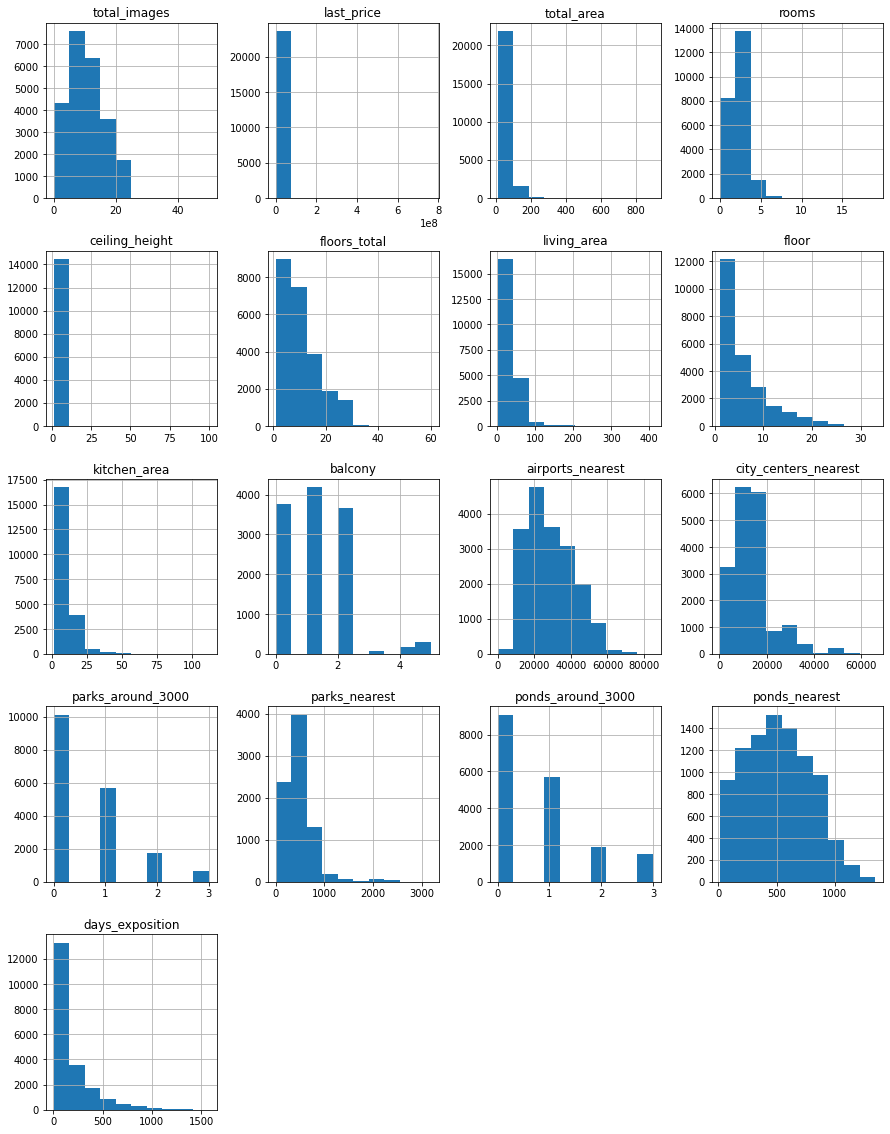

In [6]:
data.hist(figsize=(15, 20));

### Предобработка данных

посчитаем в каким столбцах есть пропуски

In [7]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
city_centers_nearest     5519
parks_around_3000        5518
parks_nearest           15620
ponds_around_3000        5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

При анализе данных о продущенных значениях получили:

1. Отсутствует информация о высоте потолков в 9195 объвлениях;
2. Отсутствует информация о количестве этажей в доме в 86 объвлениях;
3. Отсутствует информация о жилой площади в 1903 объвлениях;
4. Отсутствует информация о принадлежности к апартаментам в 20924 объвлениях;
5. Отсутствует информация о площади кухни в 2278 объвлениях;
6. Отсутствует информация о наличии балкона в 11519 объвлениях;
7. Отсутствует информация о названии населенного пункта в 49 объвлениях;  
8. Отсутствует информация о расстоянии до аэропорта в 5542 объвлениях;
9. Отсутствует информация о расстоянии до центра города в 5519 объвлениях;
10. Отсутствует информация о наличии парка в округе 3 км в 5518 объвлениях;
11. Отсутствует информация о расстоянии до ближайшего парка в 15620 объвлениях;
12. Отсутствует информация о наличии водоема в округе 3 км в 5518 объвлениях;
13. Отсутствует информация о расстоянии до ближайшего водоема в 14589 объвлениях;
14. Отсутствует информация о количестве дней на продаже в 3181 объвлениях;

#### Посмотрим на данные в столдце "высота потолков"

In [8]:
data['ceiling_height'].describe()

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

Посмотрим какие данные есть в столбце **высота потолков**

In [9]:
data['ceiling_height'].unique()

array([  2.7 ,    nan,   3.03,   2.5 ,   2.67,   2.56,   3.05,   2.75,
         2.6 ,   2.9 ,   2.8 ,   2.55,   3.  ,   2.65,   3.2 ,   2.61,
         3.25,   3.45,   2.77,   2.85,   2.64,   2.57,   4.15,   3.5 ,
         3.3 ,   2.71,   4.  ,   2.47,   2.73,   2.84,   3.1 ,   2.34,
         3.4 ,   3.06,   2.72,   2.54,   2.51,   2.78,   2.76,  25.  ,
         2.58,   3.7 ,   2.52,   5.2 ,   2.87,   2.66,   2.59,   2.  ,
         2.45,   3.6 ,   2.92,   3.11,   3.13,   3.8 ,   3.15,   3.55,
         3.16,   3.62,   3.12,   2.53,   2.74,   2.96,   2.46,   5.3 ,
         5.  ,   2.79,   2.95,   4.06,   2.94,   3.82,   3.54,   3.53,
         2.83,   4.7 ,   2.4 ,   3.38,   3.01,   5.6 ,   3.65,   3.9 ,
         3.18,   3.35,   2.3 ,   3.57,   2.48,   2.62,   2.82,   3.98,
         2.63,   3.83,   3.52,   3.95,   3.75,   2.88,   3.67,   3.87,
         3.66,   3.85,   3.86,   4.19,   3.24,   4.8 ,   4.5 ,   4.2 ,
         3.36,  32.  ,   3.08,   3.68,   3.07,   3.37,   3.09,   8.  ,
      

В данных встречаются значения 5-6 метров - можно посчитать это правдой - пентхаус или что-то подобное, но высота потолков более 20 метров похоже на ошибку. Проверим и выведем такие строки:

In [10]:
data.query('ceiling_height > 20')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
355,17,3600000.0,55.2,2018-07-12T00:00:00,2,25.0,5.0,32.0,2,False,False,False,NaN,2.0,Гатчина,NaN,NaN,NaN,NaN,NaN,NaN,259.0
3148,14,2900000.0,75.0,2018-11-12T00:00:00,3,32.0,3.0,53.0,2,NaN,False,False,8.0,NaN,Волхов,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4643,0,4300000.0,45.0,2018-02-01T00:00:00,2,25.0,9.0,30.0,2,NaN,False,False,7.0,1.0,Санкт-Петербург,12016.0,13256.0,1.0,658.0,1.0,331.0,181.0
4876,7,3000000.0,25.0,2017-09-27T00:00:00,0,27.0,25.0,17.0,17,NaN,False,True,NaN,2.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,28.0
5076,0,3850000.0,30.5,2018-10-03T00:00:00,1,24.0,5.0,19.5,1,True,False,False,5.5,NaN,Санкт-Петербург,29686.0,8389.0,3.0,397.0,1.0,578.0,7.0
5246,0,2500000.0,54.0,2017-10-13T00:00:00,2,27.0,5.0,30.0,3,NaN,False,False,9.0,2.0,деревня Мины,NaN,NaN,NaN,NaN,NaN,NaN,540.0
5669,4,4400000.0,50.0,2017-08-08T00:00:00,2,26.0,9.0,21.3,3,NaN,False,False,7.0,2.0,Санкт-Петербург,28981.0,10912.0,1.0,305.0,0.0,NaN,267.0
5807,17,8150000.0,80.0,2019-01-09T00:00:00,2,27.0,36.0,41.0,13,NaN,False,False,12.0,5.0,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,38.0
6246,6,3300000.0,44.4,2019-03-25T00:00:00,2,25.0,5.0,31.3,5,NaN,False,False,5.7,NaN,Кронштадт,68923.0,50649.0,1.0,417.0,2.0,73.0,NaN
9379,5,3950000.0,42.0,2017-03-26T00:00:00,3,25.0,5.0,30.0,2,NaN,False,False,5.2,NaN,Санкт-Петербург,11647.0,13581.0,0.0,NaN,0.0,NaN,NaN


Высота потолков 100 метров вызывает сомнениие, особенно с прощадь 14 кв метров. Далее разберемся с площадью в 100 кв. м. Будем считать, что в остальных данных, где высота потолка выше 20 метров введены ошибочно и поделим высоту потолков на 10. 

In [11]:
data['ceiling_height'].where(data['ceiling_height'] < 20, data['ceiling_height']/10, inplace=True)

In [12]:
data['ceiling_height'].where(data['ceiling_height']>2, data['ceiling_height'].median(), inplace=True)

разберемся с высотой потолков свыще 14 метров и пустыми значениями, сделаем их равными медианной величине высоты потолков

In [13]:
data.loc[(data['ceiling_height'] >= 6) | (data['ceiling_height'].isna()), 'ceiling_height'] = data['ceiling_height'].median()

In [14]:
data['ceiling_height'].describe()

count    23699.00000
mean         2.69705
std          0.21953
min          2.20000
25%          2.60000
50%          2.65000
75%          2.70000
max          5.80000
Name: ceiling_height, dtype: float64

<AxesSubplot: ylabel='Frequency'>

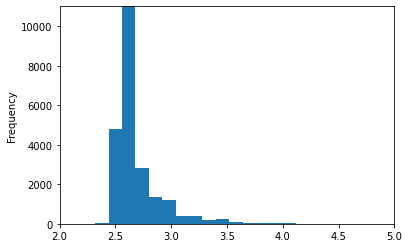

In [15]:
data['ceiling_height'].plot(kind='hist', xlim=(2,5), ylim=(0,11000), bins=30)

Средняя высота потолков 2,69 метра. Медиана 2,65. 

#### Посмотрим на данные в столце всего этажей:

In [16]:
data['floors_total'].describe()

count    23613.000000
mean        10.673824
std          6.597173
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

Ранее мы увидели, что пустых строк в данном столце 86. Посмотрим есть ли какая-либо концентрация пропущенных значений по населенному пункту

In [17]:
data.loc[data['floors_total'].isna(), 'locality_name'].value_counts()

Санкт-Петербург                    70
поселок Мурино                      2
Красное Село                        2
Кудрово                             2
посёлок Мурино                      2
поселок городского типа Токсово     1
городской посёлок Новоселье         1
посёлок Стрельна                    1
деревня Новое Девяткино             1
посёлок Щеглово                     1
посёлок Бугры                       1
посёлок Шушары                      1
Name: locality_name, dtype: int64

In [18]:
data['locality_name'].value_counts()

Санкт-Петербург                  15721
посёлок Мурино                     522
посёлок Шушары                     440
Всеволожск                         398
Пушкин                             369
                                 ...  
поселок Лисий Нос                    1
деревня Вахнова Кара                 1
деревня Каськово                     1
поселок Пансионат Зелёный Бор        1
посёлок Коробицыно                   1
Name: locality_name, Length: 364, dtype: int64

Самое большое количество пропущенных значений в столбце **итого этажей** в СПБ. При этом доля таких значений в общем объеме объектов в СПБ очень мала. Удалим строки, в которых не указано общее количество этажей

In [19]:
data.dropna(subset=['floors_total'], inplace=True)

In [20]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area              1870
floor                       0
is_apartment            20838
studio                      0
open_plan                   0
kitchen_area             2231
balcony                 11480
locality_name              48
airports_nearest         5532
city_centers_nearest     5509
parks_around_3000        5508
parks_nearest           15568
ponds_around_3000        5508
ponds_nearest           14552
days_exposition          3172
dtype: int64

#### Посмотрим на столбец **IS_APPARTMENT**

Выведем количество и список уникальных значений

In [21]:
data['is_apartment'].value_counts()

False    2725
True       50
Name: is_apartment, dtype: int64

In [22]:
data['is_apartment'].unique()

array([nan, False, True], dtype=object)

будем считать, что если значене пропущено, значит помещение не является апартаментами и заполним данные пропуски **False**

In [23]:
data['is_apartment'].where(~(data['is_apartment'].isna()), False, inplace=True)

In [24]:
data['is_apartment'].value_counts()

False    23563
True        50
Name: is_apartment, dtype: int64

####  Посмотрим на столбец BALCONY

Выведем количество и список уникальных значений

In [25]:
data['balcony'].value_counts()

1.0    4195
0.0    3713
2.0    3657
5.0     304
4.0     183
3.0      81
Name: balcony, dtype: int64

In [26]:
data['balcony'].unique()

array([nan,  2.,  0.,  1.,  5.,  4.,  3.])

будем считать, что если значене пропущено, значит что помещение не обладает балконом и заполним данные пропуски 0

In [27]:
data['balcony'].where(~(data['balcony'].isna()), 0, inplace=True)

In [28]:
data['balcony'].value_counts()

0.0    15193
1.0     4195
2.0     3657
5.0      304
4.0      183
3.0       81
Name: balcony, dtype: int64

еще раз проверим в каких ячейках остались пустые значения

In [29]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area              1870
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2231
balcony                     0
locality_name              48
airports_nearest         5532
city_centers_nearest     5509
parks_around_3000        5508
parks_nearest           15568
ponds_around_3000        5508
ponds_nearest           14552
days_exposition          3172
dtype: int64

#### Посмотрим на столбец LIVING_AREA

Посчитаем среднее отношение жилой площади к общей площади объекта.  
Заполним пропуски в столбце **living_area**, применив полученный коэффициент к общей площади этих объетов.

In [30]:
data['living_area'].describe()

count    21743.000000
mean        34.462781
std         22.037433
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        409.700000
Name: living_area, dtype: float64

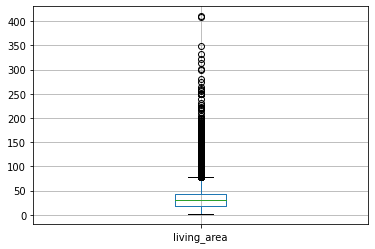

In [31]:
data.boxplot(column='living_area')
plt.show()

медиана отношения жилой площади к общей:

In [32]:
coef_liv_area = (data['living_area']/data['total_area']).median()
coef_liv_area

0.5681818181818182

In [33]:
data['living_area'].isna().sum()

1870

In [34]:
(data['living_area']
     .where(~(data['living_area'].isna()), data['total_area'] * coef_liv_area, inplace=True)
)

Жилая площадь менее 7 кв м. Удалим эти строки, посчитав эти данные некорректными

In [35]:
data[data['living_area'] < 7]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
3242,7,4440000.0,41.0,2017-07-02T00:00:00,1,2.65,17.0,3.0,17,False,False,False,11.0,0.0,Санкт-Петербург,19272.0,13073.0,0.0,NaN,0.0,NaN,216.0
13915,20,6350000.0,52.0,2018-02-06T00:00:00,2,3.00,6.0,2.0,2,False,False,False,9.0,0.0,Санкт-Петербург,32453.0,6521.0,0.0,NaN,1.0,1012.0,91.0
16431,13,3799000.0,31.0,2018-04-12T00:00:00,1,2.60,5.0,6.0,1,False,False,False,17.0,0.0,Санкт-Петербург,32177.0,4826.0,1.0,430.0,0.0,NaN,168.0
17582,11,2680000.0,22.0,2018-08-11T00:00:00,0,2.65,25.0,5.0,8,False,True,False,NaN,2.0,Санкт-Петербург,22735.0,11618.0,1.0,835.0,1.0,652.0,70.0
19251,19,4050000.0,33.0,2018-10-15T00:00:00,1,2.50,22.0,6.5,21,False,False,False,18.0,0.0,Санкт-Петербург,9258.0,10592.0,1.0,458.0,0.0,NaN,44.0
21758,0,2330000.0,23.0,2018-01-01T00:00:00,0,2.65,24.0,2.0,22,False,True,False,NaN,0.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,66.0
21943,15,6100000.0,77.6,2019-02-28T00:00:00,4,2.50,9.0,5.4,1,False,False,False,9.8,0.0,Санкт-Петербург,29338.0,11270.0,1.0,584.0,0.0,NaN,33.0
23574,14,64990000.0,139.0,2015-11-24T00:00:00,3,3.00,8.0,3.0,8,False,False,False,16.0,1.0,Санкт-Петербург,33255.0,5975.0,1.0,630.0,3.0,100.0,280.0


In [36]:
data = data[data['living_area'] >= 7]

In [37]:
data['living_area'].describe()

count    23605.000000
mean        34.597980
std         22.351454
min          7.386364
25%         19.000000
50%         30.000000
75%         42.100000
max        409.700000
Name: living_area, dtype: float64

#### Посмотрим на столбец **kitchen_area**

посчитаем среднее отношение площади кухни к общей площади объекта. Заполним пропуски в столбце **kitchen_area**, применив полученный коэффициент к общей площади этих объетов

In [38]:
data['kitchen_area'].describe()

count    21376.000000
mean        10.563313
std          5.904632
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

<AxesSubplot: >

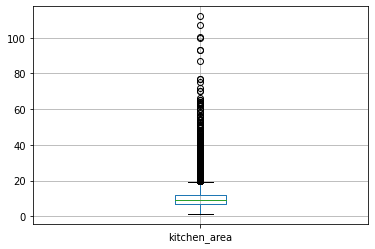

In [39]:
data.boxplot(column='kitchen_area')

In [40]:
data[data['kitchen_area'] > 40]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,False,False,False,41.0,0.0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
51,7,45000000.0,161.0,2017-10-17T00:00:00,3,3.20,8.0,38.0,4,False,False,False,50.0,0.0,Санкт-Петербург,32537.0,6589.0,0.0,NaN,3.0,99.0,541.0
263,12,39900000.0,140.6,2016-11-19T00:00:00,2,3.50,8.0,39.8,7,False,False,False,49.2,4.0,Санкт-Петербург,32537.0,6589.0,0.0,NaN,3.0,99.0,NaN
492,18,95000000.0,216.0,2017-12-05T00:00:00,4,3.00,5.0,86.0,4,False,False,False,77.0,0.0,Санкт-Петербург,21740.0,436.0,2.0,138.0,3.0,620.0,14.0
511,7,5950000.0,69.0,2017-12-21T00:00:00,1,2.65,16.0,13.0,12,False,False,False,50.0,1.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,56.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21923,10,115490000.0,235.0,2017-04-09T00:00:00,5,4.90,5.0,140.0,5,False,False,False,50.0,0.0,Санкт-Петербург,22777.0,1328.0,3.0,652.0,3.0,253.0,351.0
22494,7,91075000.0,491.0,2017-05-27T00:00:00,5,4.20,9.0,274.0,9,False,False,False,45.0,0.0,Санкт-Петербург,25525.0,5845.0,2.0,116.0,0.0,NaN,115.0
22980,19,24500000.0,155.4,2017-10-10T00:00:00,3,3.00,4.0,72.0,2,False,False,False,65.0,0.0,Санкт-Петербург,43758.0,15461.0,1.0,756.0,2.0,278.0,325.0
23327,19,34400000.0,215.0,2019-03-15T00:00:00,5,2.75,4.0,82.4,4,False,False,False,40.1,0.0,Санкт-Петербург,37268.0,15419.0,0.0,NaN,0.0,NaN,NaN


In [41]:
coef_kitch_area = (data['kitchen_area']/data['total_area']).median()

In [42]:
coef_kitch_area

0.17233373477853606

In [43]:
data['kitchen_area'].where(~(data['kitchen_area']).isna(), data['total_area']*coef_kitch_area, inplace=True)

выведем объекты у которых сумма жилой площади и площади кухни больше чем итоговая площадь

In [44]:
data[(data['living_area']+data['kitchen_area']) > data['total_area']]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
184,7,2600000.0,30.20,2018-02-14T00:00:00,1,2.65,9.0,26.10,5,False,False,False,6.200000,0.0,Санкт-Петербург,13952.0,15031.0,0.0,NaN,1.0,824.0,12.0
424,14,11500000.0,98.00,2016-05-10T00:00:00,3,2.65,3.0,88.00,3,False,False,False,16.888706,1.0,Санкт-Петербург,39363.0,13270.0,0.0,NaN,0.0,NaN,90.0
440,8,2480000.0,27.11,2018-03-12T00:00:00,0,2.65,17.0,24.75,4,False,True,False,4.671968,2.0,Санкт-Петербург,38171.0,15015.0,0.0,NaN,2.0,982.0,64.0
545,9,4700000.0,23.80,2018-12-28T00:00:00,1,2.65,18.0,20.00,9,False,False,False,5.000000,0.0,Санкт-Петербург,9731.0,11849.0,0.0,NaN,0.0,NaN,108.0
551,8,3100000.0,31.59,2018-03-08T00:00:00,1,2.70,19.0,30.55,2,False,False,False,9.280000,2.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,70.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22246,6,3100000.0,27.30,2018-05-29T00:00:00,0,2.70,16.0,23.30,15,False,True,False,4.704711,1.0,Санкт-Петербург,41935.0,9551.0,0.0,NaN,0.0,NaN,59.0
22907,9,65000000.0,228.00,2016-06-02T00:00:00,4,2.65,5.0,200.00,2,False,False,False,39.292092,0.0,Санкт-Петербург,22783.0,1295.0,3.0,619.0,3.0,269.0,NaN
23102,0,5800000.0,66.00,2017-06-09T00:00:00,5,2.65,5.0,55.50,1,False,False,False,11.374026,0.0,Санкт-Петербург,12007.0,11933.0,0.0,NaN,0.0,NaN,21.0
23191,3,1900000.0,18.90,2016-04-04T00:00:00,1,2.65,16.0,16.00,12,False,False,False,3.257108,0.0,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,115.0


удалим такие объекты

In [45]:
data = data[(data['living_area']+data['kitchen_area']) < data['total_area']]

In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23419 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23419 non-null  int64  
 1   last_price            23419 non-null  float64
 2   total_area            23419 non-null  float64
 3   first_day_exposition  23419 non-null  object 
 4   rooms                 23419 non-null  int64  
 5   ceiling_height        23419 non-null  float64
 6   floors_total          23419 non-null  float64
 7   living_area           23419 non-null  float64
 8   floor                 23419 non-null  int64  
 9   is_apartment          23419 non-null  object 
 10  studio                23419 non-null  bool   
 11  open_plan             23419 non-null  bool   
 12  kitchen_area          23419 non-null  float64
 13  balcony               23419 non-null  float64
 14  locality_name         23371 non-null  object 
 15  airports_nearest   

#### Разберемся с последними столбцами, в которых отсутcвуют данные: расстояние до аэропорта, центра города, количество прудов и парков.

Заполнить пропуски  медианным или средним значением для данных столбцов не корректно, если удалим строки - можем потерять важную информацию, т.к. доля строк с пропуском в данных столбцах более 50%. 
Заполню отсутствующие значения в этих столбцах "0".

In [47]:
data = data.fillna(0)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23419 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23419 non-null  int64  
 1   last_price            23419 non-null  float64
 2   total_area            23419 non-null  float64
 3   first_day_exposition  23419 non-null  object 
 4   rooms                 23419 non-null  int64  
 5   ceiling_height        23419 non-null  float64
 6   floors_total          23419 non-null  float64
 7   living_area           23419 non-null  float64
 8   floor                 23419 non-null  int64  
 9   is_apartment          23419 non-null  bool   
 10  studio                23419 non-null  bool   
 11  open_plan             23419 non-null  bool   
 12  kitchen_area          23419 non-null  float64
 13  balcony               23419 non-null  float64
 14  locality_name         23419 non-null  object 
 15  airports_nearest   

### Разберемся с типами данных в столбцах

#### Посмотрим на тип данных **is_apartment**

In [48]:
data['is_apartment']

0        False
1        False
2        False
3        False
4        False
         ...  
23694    False
23695    False
23696    False
23697    False
23698    False
Name: is_apartment, Length: 23419, dtype: bool

Данные в столбце типа **object**. Переведем в **BOOL**

In [49]:
data['is_apartment'] = data['is_apartment'].astype('bool')
data['is_apartment'].dtypes

dtype('bool')

#### Посмотрим на столбец **floors_total**

In [50]:
data['floors_total'].unique()   

array([16., 11.,  5., 14., 12., 26., 24., 27.,  9.,  6., 17., 25.,  3.,
       23., 19., 18.,  4., 22.,  8.,  2., 10.,  7., 13., 15., 20., 28.,
       36., 21., 35., 34., 60.,  1., 29., 33., 52., 37.])

Данные в столбце типа **Float**. Переведем в **INT**

In [51]:
data['floors_total'] = data['floors_total'].astype('int')
data['floors_total'].dtypes

dtype('int64')

In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23419 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23419 non-null  int64  
 1   last_price            23419 non-null  float64
 2   total_area            23419 non-null  float64
 3   first_day_exposition  23419 non-null  object 
 4   rooms                 23419 non-null  int64  
 5   ceiling_height        23419 non-null  float64
 6   floors_total          23419 non-null  int64  
 7   living_area           23419 non-null  float64
 8   floor                 23419 non-null  int64  
 9   is_apartment          23419 non-null  bool   
 10  studio                23419 non-null  bool   
 11  open_plan             23419 non-null  bool   
 12  kitchen_area          23419 non-null  float64
 13  balcony               23419 non-null  float64
 14  locality_name         23419 non-null  object 
 15  airports_nearest   

создадим список названий столбцов, в которых нужно поменять тип с **float64** на **int64**
Далее в цикле поменяем тип всем данным в этих столбцах

In [53]:
list_column_retype = ['last_price',
                      'balcony',
                      'airports_nearest', 
                      'city_centers_nearest', 
                      'parks_around_3000', 
                      'parks_nearest', 
                      'ponds_around_3000',
                      'ponds_nearest',
                      'days_exposition']

for i in list_column_retype:
    data[i] = data[i].astype('int')

In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23419 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23419 non-null  int64  
 1   last_price            23419 non-null  int64  
 2   total_area            23419 non-null  float64
 3   first_day_exposition  23419 non-null  object 
 4   rooms                 23419 non-null  int64  
 5   ceiling_height        23419 non-null  float64
 6   floors_total          23419 non-null  int64  
 7   living_area           23419 non-null  float64
 8   floor                 23419 non-null  int64  
 9   is_apartment          23419 non-null  bool   
 10  studio                23419 non-null  bool   
 11  open_plan             23419 non-null  bool   
 12  kitchen_area          23419 non-null  float64
 13  balcony               23419 non-null  int64  
 14  locality_name         23419 non-null  object 
 15  airports_nearest   

**Посмотрим на столбец **first_day_exposition**  
Столбец содержит дату публикации. Изменим тип данных с **Object** на **datatime**

In [55]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

#### разберемся с дубликатами в столбце **locality_name**

In [56]:
data['locality_name'].duplicated().sum()
data['locality_name'].value_counts()

Санкт-Петербург                    15528
посёлок Мурино                       509
посёлок Шушары                       438
Всеволожск                           390
Пушкин                               368
                                   ...  
деревня Нижние Осельки                 1
деревня Хязельки                       1
посёлок Платформа 69-й километр        1
поселок Пчевжа                         1
деревня Трубников Бор                  1
Name: locality_name, Length: 365, dtype: int64

Приведение к нижнему регистру 

In [57]:
data['locality_name']=data['locality_name'].str.lower()
data['locality_name'].value_counts()

санкт-петербург            15528
посёлок мурино               509
посёлок шушары               438
всеволожск                   390
пушкин                       368
                           ...  
посёлок ропша                  1
деревня лупполово              1
деревня большой сабск          1
деревня большое рейзино        1
деревня мануйлово              1
Name: locality_name, Length: 364, dtype: int64

путем приведения к нижнему регистру мы избавились от одного неявного дубликата

удалим пустые строки в населенном пункте

In [58]:
data = data.dropna(subset=['locality_name'])

удалим строки, если в населенном пункте 0

In [59]:
data = data[data['locality_name']!=0]

In [60]:
data['locality_name'].value_counts()

санкт-петербург            15528
посёлок мурино               509
посёлок шушары               438
всеволожск                   390
пушкин                       368
                           ...  
посёлок ропша                  1
деревня лупполово              1
деревня большой сабск          1
деревня большое рейзино        1
деревня мануйлово              1
Name: locality_name, Length: 364, dtype: int64

In [61]:
data['locality_name_e'] = data['locality_name'].replace('ё', 'е', regex=True)

замена **Ё** на **Е** убрала еще 4 неявных дубликата

In [62]:
list = pd.Series(data['locality_name_e'].unique())
list.sort_values().head(20)

73                        бокситогорск
61                            волосово
28                              волхов
27                          всеволожск
15                              выборг
279                             высоцк
13                             гатчина
89     городской поселок большая ижора
204         городской поселок будогощь
192          городской поселок виллози
93       городской поселок лесогорский
120              городской поселок мга
154            городской поселок назия
99         городской поселок новоселье
90           городской поселок павлово
222           городской поселок рощино
303       городской поселок свирьстрой
262        городской поселок советский
106      городской поселок федоровское
2            городской поселок янино-1
dtype: object

удалим из названий название населенного пункта, составим список, в который не включим **поселок**, удалим **Поселок** вторым этапом, чтобы корректно отработались все остальные сочетания со словом поселок

In [63]:
duplicated = ['деревня ',
              'поселок городского типа ',
              'городской поселок ',
              'садовое товарищество ',
              'поселок при железнодорожной станции',
              'поселок форт '
              'коттеджный поселок '
              'поселок пансионат '
             ]
new = ''
data['locality_name_e'].replace(duplicated, new, regex=True, inplace=True)
data['locality_name_e'].replace('поселок ', new, regex=True, inplace=True)

In [64]:
data['locality_name_e']

0         санкт-петербург
1                  шушары
2         санкт-петербург
3         санкт-петербург
4         санкт-петербург
               ...       
23694     санкт-петербург
23695               тосно
23696    село рождествено
23697     санкт-петербург
23698         новый учхоз
Name: locality_name_e, Length: 23371, dtype: object

In [65]:
data['locality_name_e'].value_counts()

санкт-петербург    15528
мурино               573
кудрово              465
шушары               438
всеволожск           390
                   ...  
кирпичное              1
хапо-ое                1
дружноселье            1
котлы                  1
малая романовка        1
Name: locality_name_e, Length: 311, dtype: int64

Осталось 311 (будем считать уникальных) населенных пунктов

проверим датафрейм на наличие явных дубликатов

In [66]:
data.duplicated().sum()

0

явных дубликатов не обнаружено  
Вывод можно сделать следущий:  
Всего 311 уникальных населенных пунктов.  
66% всех объектов недвижимости из объявлений расположено в Санкт-Петербурге. Далее населенные пункты имеют не более 2% от общей доли объявлений.

### Посчитаем и добавим в таблицу новые столбцы

#### Добавляем столбец с ценой за 1 кв.м.

In [67]:
data['price_one_meter'] = data['last_price'] / data['total_area']

#### Добавляем столбец с днем недели, в который опубликовано объявление

<AxesSubplot: >

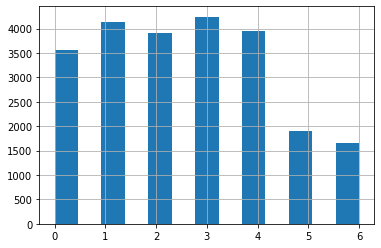

In [68]:
data['week_day'] = data['first_day_exposition'].dt.weekday 
data['week_day'].hist(bins=13)

#### Добавим месяц публикации объявления;

<AxesSubplot: >

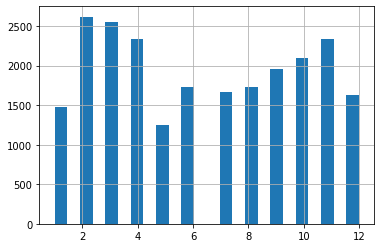

In [69]:
data['month'] = data['first_day_exposition'].dt.month
data['month'].hist(bins=24)

#### Добавим год публикации объявления

<AxesSubplot: >

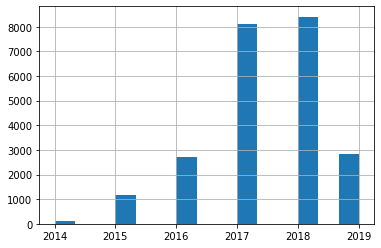

In [70]:
data['year'] = data['first_day_exposition'].dt.year
data['year'].hist(bins=15)

#### Добавим тип этажа 

In [71]:
data['type_floor'] = data['floor'].where(data['floor'] != 1, 'первый')
data['type_floor'] = data['type_floor'].where((data['floor'] != data['floors_total']) | (data['floor']== 'первый'), 'последний')
data['type_floor'] = data['type_floor'].where((data['type_floor'] == 'первый') | (data['type_floor'] == 'последний'), 'другой')
data['type_floor'].value_counts()

другой       17203
последний     3313
первый        2855
Name: type_floor, dtype: int64

<AxesSubplot: >

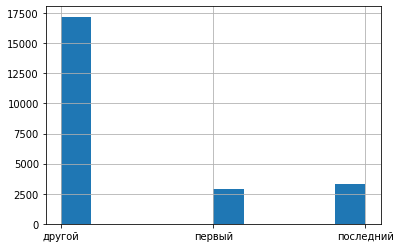

In [72]:
data['type_floor'].hist()

Количество квартир на 1 и последнем этаже составляет 25%. 75% квартир не на первом и не на последних этажах

#### расстояние до центра города в КМ

In [73]:
data['city_centers_nearest_km'] = (data['city_centers_nearest']/1000).round()
data['city_centers_nearest_km'].astype('int')

0        16
1        19
2        14
3         7
4         8
         ..
23694     4
23695     0
23696     0
23697    10
23698     0
Name: city_centers_nearest_km, Length: 23371, dtype: int64

### Проведем исследовательский анализ данных

#### Проанализируем общую площадь

здесь и далее по каждому параметрувыведем основные статистические показатели методом **describe()**

In [74]:
data['total_area'].describe()

count    23371.000000
mean        60.389696
std         35.683661
min         13.000000
25%         40.000000
50%         52.000000
75%         69.800000
max        900.000000
Name: total_area, dtype: float64

построим диаграму размаха, чтобы посмотреть выбросы

<AxesSubplot: >

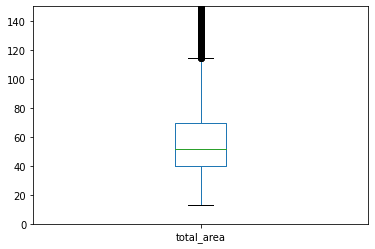

In [75]:
data['total_area'].plot(kind='box', ylim=(0,150))

построим столбчатую гистограмму, чтобы посмотреть распределение

Text(0, 0.5, 'Количество квартир')

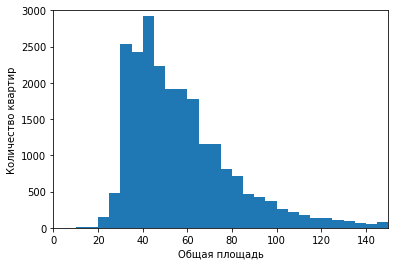

In [76]:
data['total_area'].plot(kind='hist', xlim=(0,150), ylim=(0,3000), bins=30, range=(0,150))
plt.xlabel('Общая площадь')
plt.ylabel('Количество квартир')

выведем строки, в которых, по моему мнению, значение общей площади "слишком большое"

In [77]:
data[data['total_area'] > 300]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition,locality_name_e,price_one_meter,week_day,month,year,type_floor,city_centers_nearest_km
155,8,96000000,317.0,2017-07-07,4,3.50,3,183.000000,3,False,False,False,54.629794,1,санкт-петербург,22673,1771,2,508,3,366,62,санкт-петербург,302839.116719,4,7,2017,последний,2.0
581,20,65000000,365.0,2019-03-18,7,2.90,7,207.386364,7,False,False,False,62.901813,0,санкт-петербург,19827,1690,3,378,3,58,0,санкт-петербург,178082.191781,0,3,2019,последний,2.0
660,3,49950000,483.9,2017-10-04,7,3.20,6,312.500000,4,False,False,False,26.400000,0,санкт-петербург,23079,945,3,461,3,22,391,санкт-петербург,103223.806572,2,10,2017,другой,1.0
793,20,135000000,310.0,2018-05-22,4,3.30,5,250.000000,2,False,False,False,50.000000,0,санкт-петербург,34159,7251,2,295,3,190,342,санкт-петербург,435483.870968,1,5,2018,другой,7.0
866,5,25000000,363.0,2017-12-23,14,3.16,5,222.000000,4,False,False,False,16.600000,0,санкт-петербург,38076,7950,0,0,2,435,418,санкт-петербург,68870.523416,5,12,2017,другой,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20820,7,73900000,342.0,2015-06-18,5,2.65,4,187.000000,2,False,False,False,10.000000,0,санкт-петербург,25079,5544,0,0,1,251,377,санкт-петербург,216081.871345,3,6,2015,другой,6.0
21955,19,130000000,431.0,2017-10-02,7,3.70,8,220.000000,5,False,False,False,20.000000,5,санкт-петербург,0,0,0,0,0,0,161,санкт-петербург,301624.129930,0,10,2017,другой,0.0
21990,20,68000000,373.1,2018-09-08,8,2.65,8,176.200000,8,False,False,False,29.400000,0,санкт-петербург,37965,7873,1,562,3,691,234,санкт-петербург,182256.767623,5,9,2018,последний,8.0
22131,14,27000000,422.2,2018-10-18,5,2.70,13,239.886364,11,False,False,False,72.759303,0,санкт-петербург,46625,16554,0,0,0,0,0,санкт-петербург,63950.734249,3,10,2018,другой,17.0


выведем строки, в которых, по моему мнению, значение общей площади "слишком маленькое"

In [78]:
data[data['total_area'] < 15]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition,locality_name_e,price_one_meter,week_day,month,year,type_floor,city_centers_nearest_km
17961,3,1400000,13.0,2017-12-03,1,2.60,9,7.386364,1,False,False,False,2.240339,0,санкт-петербург,14350,15945,0,0,1,185,410,санкт-петербург,107692.307692,6,12,2017,первый,16.0
19546,3,1850000,13.0,2019-03-11,1,3.40,5,7.386364,2,False,False,False,2.240339,0,санкт-петербург,24915,5483,1,644,0,0,24,санкт-петербург,142307.692308,0,3,2019,другой,5.0
19558,2,1686000,13.2,2018-12-17,1,2.65,5,7.500000,1,False,False,False,2.274805,0,санкт-петербург,19891,4165,1,361,1,155,19,санкт-петербург,127727.272727,0,12,2018,первый,4.0
19642,5,1190000,14.0,2018-07-29,1,2.65,5,11.000000,1,False,False,False,2.000000,0,санкт-петербург,9898,11122,0,0,0,0,4,санкт-петербург,85000.000000,6,7,2018,первый,11.0
19807,0,3800000,13.0,2018-07-04,1,2.65,5,10.000000,3,False,False,False,2.240339,0,санкт-петербург,21302,1242,1,592,3,27,9,санкт-петербург,292307.692308,2,7,2018,другой,1.0


Среднее значение общей площади квартиры 60 кв метров. Медиана - 52 кв метра.
Три четверти всех квартир имеют площадь до 69 кв.м. 
Есть выбросы - квартиры с площадью больше 300 кв.м.  - 61 квартира

#### Проанализируем жилую площаль

In [79]:
data['living_area'].describe()

count    23371.000000
mean        34.528594
std         22.306317
min          7.386364
25%         19.000000
50%         30.000000
75%         42.022727
max        409.700000
Name: living_area, dtype: float64

<AxesSubplot: >

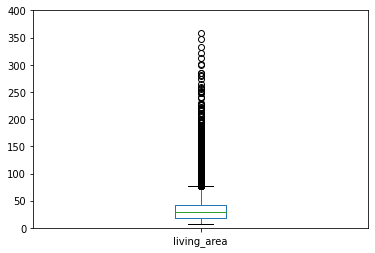

In [80]:
data['living_area'].plot(kind='box', ylim=(0,400))

Text(0, 0.5, 'Количество квартир')

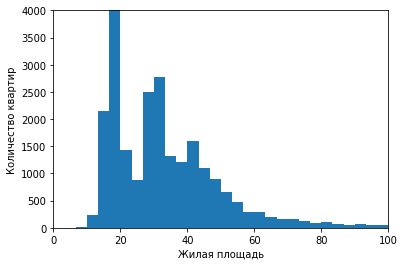

In [81]:
data['living_area'].plot(kind='hist', xlim=(0,100), ylim=(0,4000), bins=30, range=(0,100))
plt.xlabel('Жилая площадь')
plt.ylabel('Количество квартир')

In [82]:
data[data['living_area'] > 100]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition,locality_name_e,price_one_meter,week_day,month,year,type_floor,city_centers_nearest_km
35,6,15500000,149.0,2017-06-26,5,2.65,5,104.00,4,False,False,False,17.000000,0,санкт-петербург,23670,3502,0,0,1,779,644,санкт-петербург,104026.845638,0,6,2017,другой,4.0
155,8,96000000,317.0,2017-07-07,4,3.50,3,183.00,3,False,False,False,54.629794,1,санкт-петербург,22673,1771,2,508,3,366,62,санкт-петербург,302839.116719,4,7,2017,последний,2.0
335,1,21800000,163.4,2017-12-10,5,3.50,5,119.50,2,False,False,False,10.000000,0,санкт-петербург,26791,5493,1,349,0,0,106,санкт-петербург,133414.932681,6,12,2017,другой,5.0
417,5,14200000,178.0,2017-10-26,5,3.30,4,126.60,2,False,False,False,19.400000,0,санкт-петербург,24287,2835,0,0,3,257,104,санкт-петербург,79775.280899,3,10,2017,другой,3.0
464,15,66571000,280.3,2015-06-11,6,5.20,8,159.50,7,False,False,False,21.100000,0,санкт-петербург,26316,6655,3,187,1,616,578,санкт-петербург,237499.108098,3,6,2015,другой,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23299,20,25900000,167.1,2017-08-28,4,2.75,15,102.30,6,False,False,False,22.300000,1,санкт-петербург,29860,7232,0,0,3,212,110,санкт-петербург,154997.007780,0,8,2017,другой,7.0
23395,4,40000000,188.0,2017-05-29,6,2.65,6,109.51,4,False,False,False,31.300000,0,санкт-петербург,23390,2254,2,425,1,62,30,санкт-петербург,212765.957447,0,5,2017,другой,2.0
23400,17,30000000,213.0,2017-09-28,7,3.40,5,151.40,5,False,False,False,30.800000,0,санкт-петербург,21146,1225,2,342,3,30,299,санкт-петербург,140845.070423,3,9,2017,последний,1.0
23448,3,14700000,180.0,2018-02-08,6,3.00,6,126.00,5,False,False,False,20.000000,0,санкт-петербург,23955,5089,0,0,2,616,0,санкт-петербург,81666.666667,3,2,2018,другой,5.0


In [83]:
data[(data['living_area'] <10)]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition,locality_name_e,price_one_meter,week_day,month,year,type_floor,city_centers_nearest_km
114,5,4000000,21.40,2019-02-07,1,2.90,8,8.300000,7,False,False,False,6.300000,0,санкт-петербург,27089,5791,2,488,1,286,0,санкт-петербург,186915.887850,3,2,2019,другой,6.0
680,14,7200000,43.00,2017-10-31,1,2.65,8,9.000000,2,False,False,False,23.000000,0,санкт-петербург,23900,5232,1,2137,1,933,296,санкт-петербург,167441.860465,1,10,2017,другой,5.0
1326,8,8100000,52.00,2017-01-29,2,2.70,25,9.000000,15,False,False,False,32.000000,2,санкт-петербург,35555,15561,0,0,1,1180,337,санкт-петербург,155769.230769,6,1,2017,другой,16.0
2309,10,4200000,62.40,2017-06-15,2,2.60,9,8.400000,6,False,False,False,41.000000,2,посёлок шушары,23662,29448,0,0,0,0,111,шушары,67307.692308,3,6,2017,другой,29.0
4100,17,5300000,34.80,2017-06-19,1,2.70,23,9.000000,15,False,False,False,17.100000,0,санкт-петербург,33626,13495,0,0,0,0,30,санкт-петербург,152298.850575,0,6,2017,другой,13.0
4542,12,3300000,18.00,2018-11-07,1,3.50,5,9.000000,2,False,False,False,3.102007,0,санкт-петербург,25157,4948,2,349,1,963,9,санкт-петербург,183333.333333,2,11,2018,другой,5.0
7312,8,3400000,27.00,2018-02-21,2,2.50,15,9.000000,4,False,False,False,16.000000,0,санкт-петербург,50246,16444,1,617,0,0,0,санкт-петербург,125925.925926,2,2,2018,другой,16.0
8325,9,4800000,52.00,2017-10-25,2,2.65,5,9.000000,2,False,False,False,6.000000,1,санкт-петербург,33358,13171,0,0,2,118,119,санкт-петербург,92307.692308,2,10,2017,другой,13.0
12040,5,1900000,15.00,2018-06-27,1,2.50,5,8.522727,1,False,False,False,2.585006,0,сосновый бор,0,0,0,0,0,0,45,сосновый бор,126666.666667,2,6,2018,первый,0.0
15833,20,4600000,33.00,2017-01-01,1,2.70,22,9.000000,12,False,False,False,14.300000,1,санкт-петербург,33803,13671,0,0,0,0,511,санкт-петербург,139393.939394,6,1,2017,другой,14.0


Максимальное количетсво квартир имеют площадь 20 метров.  
Среднее значение жилой площади квартиры 34 кв метров. Медиана - 30 кв метра. Три четверти всех квартир имеют жилую площадь до 42 кв.м. Есть выбросы - квартиры с  жилой площадью больше 100 кв.м. - 385 квартир
С жилой площадью меньше 10 кв м - 17 квартир

#### Изучим площадь кухни

In [84]:
data['kitchen_area'].describe()

count    23371.000000
mean        10.460916
std          5.985031
min          1.300000
25%          7.000000
50%          9.000000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

In [85]:

data[data['kitchen_area'] < 4]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition,locality_name_e,price_one_meter,week_day,month,year,type_floor,city_centers_nearest_km
716,5,1500000,17.00,2017-06-07,0,2.70,9,12.000000,1,False,True,False,2.929673,0,посёлок шушары,18654,29846,0,0,0,0,40,шушары,88235.294118,2,6,2017,первый,30.0
906,15,2600000,27.00,2017-07-10,1,2.75,23,18.000000,18,False,False,False,2.000000,0,санкт-петербург,22131,17459,0,0,1,411,10,санкт-петербург,96296.296296,0,7,2017,другой,17.0
946,5,2200000,23.00,2016-09-27,0,2.65,27,18.000000,7,False,False,True,3.963676,2,посёлок мурино,0,0,0,0,0,0,483,мурино,95652.173913,1,9,2016,другой,0.0
1194,14,2520000,22.70,2018-08-31,1,2.65,14,13.500000,5,False,False,False,3.911976,0,санкт-петербург,22735,11907,1,1065,1,484,7,санкт-петербург,111013.215859,4,8,2018,другой,12.0
1280,10,2200000,23.00,2018-03-06,1,2.65,24,17.000000,21,False,False,False,3.963676,0,посёлок мурино,0,0,0,0,0,0,42,мурино,95652.173913,1,3,2018,другой,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21552,4,1495000,22.00,2019-01-27,1,2.65,18,12.500000,18,False,False,False,3.791342,2,никольское,0,0,0,0,0,0,0,никольское,67954.545455,6,1,2019,последний,0.0
21718,11,2540000,23.00,2018-03-22,1,2.65,5,13.068182,1,False,False,False,3.963676,0,санкт-петербург,27289,7997,0,0,1,698,45,санкт-петербург,110434.782609,3,3,2018,первый,8.0
21981,6,2000000,21.57,2018-04-19,1,2.65,19,15.100000,13,False,False,False,3.717239,0,посёлок мурино,0,0,0,0,0,0,144,мурино,92721.372276,3,4,2018,другой,0.0
22356,6,2050000,17.20,2019-01-13,1,2.77,23,9.772727,1,False,False,False,2.964140,0,санкт-петербург,33645,13513,0,0,0,0,7,санкт-петербург,119186.046512,6,1,2019,первый,14.0


<AxesSubplot: >

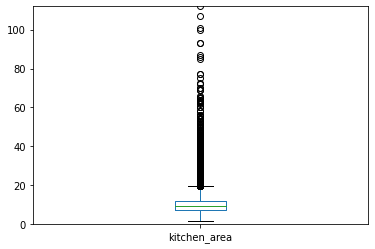

In [86]:
data['kitchen_area'].plot(kind='box', ylim=(0,112))

In [87]:
data[data['kitchen_area'] > 50]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition,locality_name_e,price_one_meter,week_day,month,year,type_floor,city_centers_nearest_km
155,8,96000000,317.0,2017-07-07,4,3.50,3,183.000000,3,False,False,False,54.629794,1,санкт-петербург,22673,1771,2,508,3,366,62,санкт-петербург,3.028391e+05,4,7,2017,последний,2.0
492,18,95000000,216.0,2017-12-05,4,3.00,5,86.000000,4,False,False,False,77.000000,0,санкт-петербург,21740,436,2,138,3,620,14,санкт-петербург,4.398148e+05,1,12,2017,другой,0.0
581,20,65000000,365.0,2019-03-18,7,2.90,7,207.386364,7,False,False,False,62.901813,0,санкт-петербург,19827,1690,3,378,3,58,0,санкт-петербург,1.780822e+05,0,3,2019,последний,2.0
1026,20,155000000,310.0,2018-10-12,5,5.30,3,190.000000,3,False,False,False,63.000000,2,санкт-петербург,24899,4785,0,0,1,603,0,санкт-петербург,5.000000e+05,4,10,2018,последний,5.0
1085,16,75000000,323.0,2017-07-10,5,4.00,5,255.700000,4,False,False,False,66.000000,0,санкт-петербург,23713,594,3,398,2,515,259,санкт-петербург,2.321981e+05,0,7,2017,другой,1.0
1388,20,59800000,399.0,2015-01-21,5,5.60,6,226.704545,6,False,False,False,68.761160,0,санкт-петербург,26204,6934,2,149,2,577,719,санкт-петербург,1.498747e+05,2,1,2015,последний,7.0
2243,9,130278280,304.0,2015-07-24,5,3.11,9,172.727273,7,False,False,False,52.389455,0,санкт-петербург,25593,5913,2,164,0,0,599,санкт-петербург,4.285470e+05,4,7,2015,другой,6.0
2489,9,12500000,255.0,2017-04-21,3,2.65,2,153.900000,2,False,False,False,100.700000,0,санкт-петербург,29544,6916,0,0,3,198,102,санкт-петербург,4.901961e+04,4,4,2017,последний,7.0
3117,19,140000000,631.0,2019-03-30,7,2.65,5,358.522727,5,False,False,False,60.000000,0,санкт-петербург,25707,4972,0,0,2,210,0,санкт-петербург,2.218700e+05,5,3,2019,последний,5.0
3561,5,12300000,115.0,2017-08-09,3,2.70,20,45.000000,16,False,False,False,60.000000,1,санкт-петербург,33386,14234,0,0,0,0,63,санкт-петербург,1.069565e+05,2,8,2017,другой,14.0


Text(0, 0.5, 'Количество квартир')

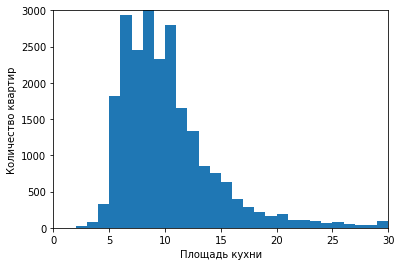

In [88]:
data['kitchen_area'].plot(kind='hist', xlim=(0,30), ylim=(0,3000), bins=30, range=(0,30))
plt.xlabel('Площадь кухни')
plt.ylabel('Количество квартир')

Максимальное количество квартир имеют площадь кухни от 6 до 12 кв метров.  
Среднее значение площади кухни 10,4 кв метров. Медиана - 9 кв метра. Три четверти всех квартир имеют жилую площадь до 11,9 кв.м. Есть выбросы - квартиры с площадью кухни больше 50 кв.м. - 48 квартир. С  площадью кухни менее 4 кв м - 79 квартир

#### Проанализируем цену объектов

In [89]:
data['last_price'].describe().apply("{0:6.2f}".format)

count        23371.00
mean       6535634.35
std       10890289.50
min          12190.00
25%        3429500.00
50%        4650000.00
75%        6790000.00
max      763000000.00
Name: last_price, dtype: object

In [90]:
data = data[data['last_price'] > 200000]

<AxesSubplot: >

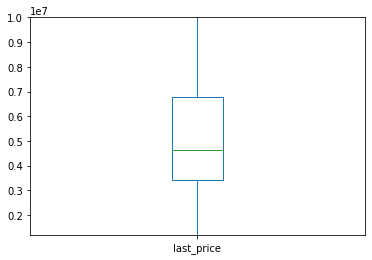

In [91]:
data['last_price'].plot(kind='box', ylim=(1200000,10000000))

Text(0, 0.5, 'Количество квартир')

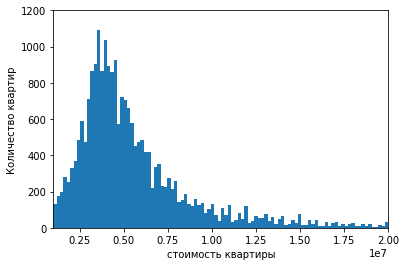

In [92]:
data['last_price'].plot(kind='hist', xlim=(1000000,20000000), ylim=(0,1200), bins=100, range=(1000000, 20000000))
plt.xlabel('стоимость квартиры')
plt.ylabel('Количество квартир')

In [93]:
data[data['last_price'] > 20000000]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition,locality_name_e,price_one_meter,week_day,month,year,type_floor,city_centers_nearest_km
3,0,64900000,159.0,2015-07-24,3,2.65,14,90.340909,9,False,False,False,27.401064,0,санкт-петербург,28098,6800,2,84,3,234,424,санкт-петербург,408176.100629,4,7,2015,другой,7.0
42,13,22000000,161.8,2015-07-08,4,2.80,4,80.900000,2,False,False,False,17.600000,5,петергоф,35416,30605,2,47,1,907,987,петергоф,135970.333745,2,7,2015,другой,31.0
51,7,45000000,161.0,2017-10-17,3,3.20,8,38.000000,4,False,False,False,50.000000,0,санкт-петербург,32537,6589,0,0,3,99,541,санкт-петербург,279503.105590,1,10,2017,другой,7.0
121,20,33000000,180.0,2017-02-17,3,2.90,9,86.000000,8,False,False,False,24.000000,4,санкт-петербург,25689,4264,1,633,0,0,144,санкт-петербург,183333.333333,4,2,2017,другой,4.0
147,10,27700000,179.6,2017-07-06,5,2.85,25,97.200000,25,False,False,False,33.800000,2,санкт-петербург,19424,4489,0,0,1,806,75,санкт-петербург,154231.625835,3,7,2017,последний,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23400,17,30000000,213.0,2017-09-28,7,3.40,5,151.400000,5,False,False,False,30.800000,0,санкт-петербург,21146,1225,2,342,3,30,299,санкт-петербург,140845.070423,3,9,2017,последний,1.0
23446,19,27000000,110.0,2016-03-11,3,2.65,7,63.000000,5,False,False,False,15.000000,1,санкт-петербург,26819,5026,1,657,1,678,200,санкт-петербург,245454.545455,4,3,2016,другой,5.0
23491,20,21800000,250.0,2017-09-16,3,2.65,12,104.000000,7,False,False,False,45.000000,0,санкт-петербург,43558,13138,0,0,0,0,49,санкт-петербург,87200.000000,5,9,2017,другой,13.0
23516,3,22529250,139.5,2018-07-04,4,3.30,16,82.550000,9,False,False,False,13.840000,0,санкт-петербург,37434,8460,1,441,2,427,266,санкт-петербург,161500.000000,2,7,2018,другой,8.0


In [94]:
data[data['last_price'] < 1000000]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition,locality_name_e,price_one_meter,week_day,month,year,type_floor,city_centers_nearest_km
164,6,800000,40.3,2018-06-25,2,2.65,3,22.897727,1,False,False,False,6.945050,2,поселок городского типа ефимовский,0,0,0,0,0,0,81,ефимовский,19851.116625,0,6,2018,первый,0.0
247,7,650000,31.0,2017-01-20,1,2.65,3,17.613636,1,False,False,False,5.342346,0,сланцы,0,0,0,0,0,0,378,сланцы,20967.741935,4,1,2017,первый,0.0
259,6,900000,30.0,2017-11-21,1,2.50,5,15.000000,4,False,False,False,5.000000,1,ивангород,0,0,0,0,0,0,0,ивангород,30000.000000,1,11,2017,другой,0.0
268,7,650000,46.0,2018-03-15,2,2.50,5,30.000000,5,False,False,False,7.000000,0,сланцы,0,0,0,0,0,0,75,сланцы,14130.434783,3,3,2018,последний,0.0
293,2,900000,42.8,2017-06-14,2,2.65,5,32.000000,5,False,False,False,5.000000,0,сясьстрой,0,0,0,0,0,0,247,сясьстрой,21028.037383,2,6,2017,последний,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23067,8,600000,31.8,2019-04-24,1,2.65,2,20.000000,1,False,False,False,7.000000,0,деревня коркино,0,0,0,0,0,0,0,коркино,18867.924528,2,4,2019,первый,0.0
23153,9,650000,41.0,2017-10-13,2,2.65,3,28.000000,1,False,False,False,6.000000,0,бокситогорск,0,0,0,0,0,0,14,бокситогорск,15853.658537,4,10,2017,первый,0.0
23354,18,900000,42.6,2018-02-26,2,2.65,2,28.000000,1,False,False,False,9.000000,0,деревня тихковицы,0,0,0,0,0,0,219,тихковицы,21126.760563,0,2,2018,первый,0.0
23484,11,470000,44.5,2018-07-02,2,2.65,2,28.000000,2,False,False,False,7.500000,0,сланцы,0,0,0,0,0,0,298,сланцы,10561.797753,0,7,2018,последний,0.0


Наибольшее количество квартир стоят 3,5-5 млн рублей.  
Среднее стоимость квартиры 6,4 млн рублей. Медиана - 4,6 млн. Три четверти всех квартир  имеют стоимость до 6,7 млн рублей. Есть выбросы - квартиры стоимостью больше 20 млн 602 квартиры. Стоимостью менее 1 млн - 176 квартир

#### Проанализируем количество комнат

In [95]:
data['rooms'].describe()

count    23370.000000
mean         2.073599
std          1.077299
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

проверим, есть ли квартиры, в которых нет комнат, при этом в квартире не свободная планировка и не студия

In [96]:
data[(data['rooms'] == 0)&(data['studio']!=True)&(data['open_plan']!=True)]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition,locality_name_e,price_one_meter,week_day,month,year,type_floor,city_centers_nearest_km


таких квартир нет

<AxesSubplot: >

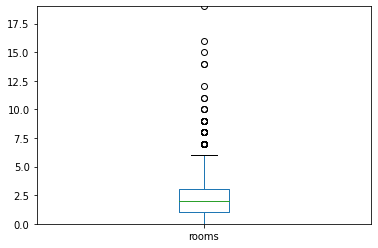

In [97]:
data['rooms'].plot(kind='box', ylim=(0,19))

Text(0, 0.5, 'Количество квартир')

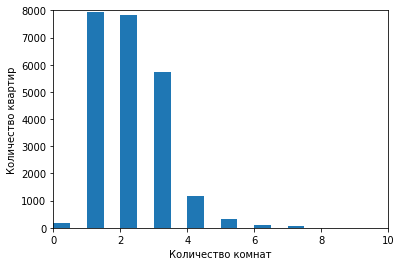

In [98]:
data['rooms'].plot(kind='hist', xlim=(0,10), ylim=(0,8000), bins=20, range=(0,10))
plt.xlabel('Количество комнат')
plt.ylabel('Количество квартир')

In [99]:
data[data['rooms'] > 5]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition,locality_name_e,price_one_meter,week_day,month,year,type_floor,city_centers_nearest_km
52,20,11795000,136.0,2017-09-22,6,3.00,2,94.000000,2,False,False,False,11.000000,1,санкт-петербург,16510,6582,1,526,0,0,0,санкт-петербург,86727.941176,4,9,2017,последний,7.0
201,5,10880000,123.1,2015-11-12,6,3.20,5,89.000000,2,False,False,False,11.000000,0,санкт-петербург,26009,3369,2,516,0,0,992,санкт-петербург,88383.428107,3,11,2015,другой,3.0
464,15,66571000,280.3,2015-06-11,6,5.20,8,159.500000,7,False,False,False,21.100000,0,санкт-петербург,26316,6655,3,187,1,616,578,санкт-петербург,237499.108098,3,6,2015,другой,7.0
509,5,90000000,225.0,2016-06-26,6,2.65,4,134.000000,2,False,False,False,19.500000,2,санкт-петербург,32864,5720,0,0,2,519,416,санкт-петербург,400000.000000,6,6,2016,другой,6.0
581,20,65000000,365.0,2019-03-18,7,2.90,7,207.386364,7,False,False,False,62.901813,0,санкт-петербург,19827,1690,3,378,3,58,0,санкт-петербург,178082.191781,0,3,2019,последний,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23281,20,24800000,231.2,2015-01-21,6,3.10,5,99.800000,4,False,False,False,27.400000,0,санкт-петербург,21480,2453,3,75,1,795,0,санкт-петербург,107266.435986,2,1,2015,другой,2.0
23395,4,40000000,188.0,2017-05-29,6,2.65,6,109.510000,4,False,False,False,31.300000,0,санкт-петербург,23390,2254,2,425,1,62,30,санкт-петербург,212765.957447,0,5,2017,другой,2.0
23400,17,30000000,213.0,2017-09-28,7,3.40,5,151.400000,5,False,False,False,30.800000,0,санкт-петербург,21146,1225,2,342,3,30,299,санкт-петербург,140845.070423,3,9,2017,последний,1.0
23448,3,14700000,180.0,2018-02-08,6,3.00,6,126.000000,5,False,False,False,20.000000,0,санкт-петербург,23955,5089,0,0,2,616,0,санкт-петербург,81666.666667,3,2,2018,другой,5.0


Наибольшее количесто объявлений имеют 1 или 2 комнаты.
Среднее количество комнат равно 2. Медиана тоже равна 2. Три четверти всех квартир  имеют 3 комнаты. Есть выбросы - квартиры с более чем 5 комнатами - 179 квартиры.

#### ПРоанализируем этаж квартиры

In [100]:
data['floor'].describe()

count    23370.000000
mean         5.870133
std          4.861173
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

<AxesSubplot: >

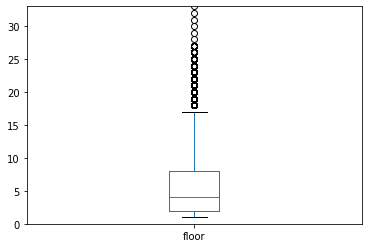

In [101]:
data['floor'].plot(kind='box', ylim=(0,33))

Text(0, 0.5, 'Количество квартир')

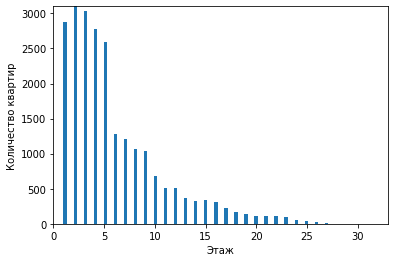

In [102]:
data['floor'].plot(kind='hist', xlim=(0,33), ylim=(0,3100), bins=100, xlabel='этаж', range=(0,33))
plt.xlabel('Этаж')
plt.ylabel('Количество квартир')

In [103]:
data[data['floor'] > 20]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition,locality_name_e,price_one_meter,week_day,month,year,type_floor,city_centers_nearest_km
7,5,7915000,71.60,2019-04-18,2,2.65,24,40.681818,22,False,False,False,18.900000,2,санкт-петербург,23982,11634,0,0,0,0,0,санкт-петербург,110544.692737,3,4,2019,другой,12.0
8,20,2900000,33.16,2018-05-23,1,2.65,27,15.430000,26,False,False,False,8.810000,0,посёлок мурино,0,0,0,0,0,0,189,мурино,87454.764777,2,5,2018,другой,0.0
40,9,3590000,36.00,2017-03-15,1,2.60,26,15.000000,22,False,False,False,10.000000,2,посёлок парголово,52996,19143,0,0,0,0,430,парголово,99722.222222,2,3,2017,другой,19.0
113,8,5750000,78.00,2016-05-19,3,2.65,27,45.400000,27,False,False,False,10.800000,2,посёлок парголово,53134,19311,0,0,0,0,426,парголово,73717.948718,3,5,2016,последний,19.0
147,10,27700000,179.60,2017-07-06,5,2.85,25,97.200000,25,False,False,False,33.800000,2,санкт-петербург,19424,4489,0,0,1,806,75,санкт-петербург,154231.625835,3,7,2017,последний,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23455,3,4300000,45.80,2015-06-10,1,2.65,26,18.200000,22,False,False,False,12.300000,0,санкт-петербург,45827,18193,0,0,0,0,453,санкт-петербург,93886.462882,2,6,2015,другой,18.0
23456,5,3950000,39.50,2017-11-11,1,2.75,26,16.700000,21,False,False,False,10.400000,0,посёлок парголово,52768,17994,0,0,0,0,298,парголово,100000.000000,5,11,2017,другой,18.0
23476,0,11000000,75.70,2018-11-14,2,2.70,23,33.900000,21,False,False,False,12.100000,0,санкт-петербург,7659,13841,0,0,0,0,13,санкт-петербург,145310.435931,2,11,2018,другой,14.0
23504,20,4800000,42.50,2017-04-18,1,2.80,26,15.600000,21,False,False,False,11.000000,2,санкт-петербург,20028,21740,0,0,1,400,128,санкт-петербург,112941.176471,1,4,2017,другой,22.0


Наибольшее количество квартир располножены на 2-3 этажах
Средний этаж - 6. Медиана - 4. Три четверти всех квартир располагаются с 1 по 8 этаж. Есть квартиры, которые расположены выше 20 этажа - таких 428 квартир.

#### Проанализируем общее количество этажей в доме

In [104]:
data['floors_total'].describe()

count    23370.000000
mean        10.663885
std          6.582488
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

<AxesSubplot: >

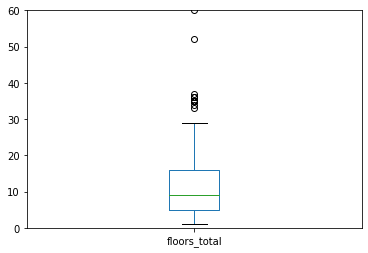

In [105]:
data['floors_total'].plot(kind='box', ylim=(0,60))

Text(0, 0.5, 'Количество квартир')

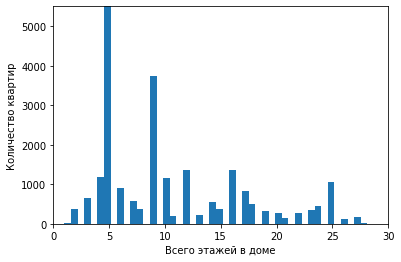

In [106]:
data['floors_total'].plot(kind='hist', xlim=(0,30), ylim=(0,5500), bins=100)
plt.xlabel('Всего этажей в доме')
plt.ylabel('Количество квартир')

Средний количество этажей - 10. Медиана - 9. Всплески видны на 5, 9, 12, 16 и 25 этажных домах. Не удивительно, большинство домов 5ти и 9ти этажные.

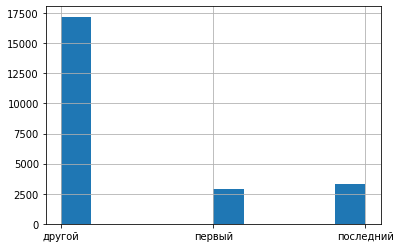

In [107]:
data['type_floor'].hist();

Количество квартир на 1 и последнем этаже составляет 25%. 75% квартир не на первом и не на последних этажах

#### Проанализируем расстояние до центра города в метрах;

исключим из анализа расстояние до центра города =0, т.к. мы заполняли пропуски нулями.

In [108]:
data.query("city_centers_nearest > 0")['city_centers_nearest'].describe()

count    17932.000000
mean     14205.736337
std       8618.805444
min        181.000000
25%       9241.000000
50%      13105.000000
75%      16293.000000
max      65968.000000
Name: city_centers_nearest, dtype: float64

<AxesSubplot: >

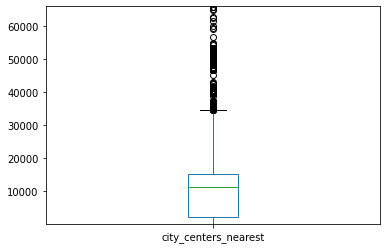

In [109]:
data['city_centers_nearest'].plot(kind='box', ylim=(181,66000))

Text(0, 0.5, 'Количество квартир')

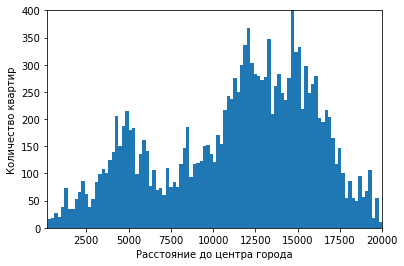

In [110]:
data['city_centers_nearest'].plot(kind='hist', xlim=(181,20000) , ylim=(0,400), bins=100, range=(1,20000))
plt.xlabel('Расстояние до центра города')
plt.ylabel('Количество квартир')

In [111]:
data[data['city_centers_nearest']>20000]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition,locality_name_e,price_one_meter,week_day,month,year,type_floor,city_centers_nearest_km
11,9,3300000,44.0,2018-08-27,2,2.65,5,31.0,4,False,False,False,6.0,1,ломоносов,48252,51677,0,0,0,0,7,ломоносов,75000.000000,0,8,2018,другой,52.0
13,20,3550000,42.8,2017-07-01,2,2.56,5,27.0,5,False,False,False,5.2,1,петергоф,37868,33058,1,294,3,298,366,петергоф,82943.925234,5,7,2017,последний,33.0
14,1,4400000,36.0,2016-06-23,1,2.65,6,17.0,1,False,False,False,8.0,0,пушкин,20782,30759,0,0,1,96,203,пушкин,122222.222222,3,6,2016,первый,31.0
28,8,4170000,44.0,2017-12-13,1,2.90,6,20.8,1,False,False,False,11.7,1,пушкин,18557,30710,0,0,1,118,74,пушкин,94772.727273,2,12,2017,первый,31.0
33,8,4800000,73.0,2018-10-15,4,2.65,9,51.6,5,False,False,False,6.5,0,колпино,26535,32321,0,0,0,0,92,колпино,65753.424658,0,10,2018,другой,32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23667,14,9990000,90.0,2017-01-23,3,3.06,17,55.0,9,False,False,False,11.0,2,сестрорецк,56343,33272,0,0,1,545,86,сестрорецк,111000.000000,0,1,2017,другой,33.0
23669,8,3000000,34.1,2017-11-10,1,2.65,9,17.0,3,False,False,False,9.0,1,колпино,24687,30473,0,0,1,741,74,колпино,87976.539589,4,11,2017,другой,30.0
23678,10,3500000,43.0,2016-05-19,2,2.50,3,26.1,2,False,False,False,4.9,1,пушкин,15823,27977,0,0,1,1134,252,пушкин,81395.348837,3,5,2016,другой,28.0
23685,15,2490000,31.0,2019-01-24,1,2.50,5,17.3,5,False,False,False,5.6,1,ломоносов,48393,51818,0,0,0,0,0,ломоносов,80322.580645,3,1,2019,последний,52.0


Наибольшее количество квартир располагаются на расстоянии 12 и 15 км от центра города.
Средний расстояние до центра города - 14,2 км. Медиана - 13,1 км. Три четверти всех квартир располагаются  на расстоянии не более 16 км. Есть квартиры, которые расположены дальше 20 км - таких 2421 квартира.

#### Проанализируем расстояние до ближайшего аэропорта

исключим из анализа расстояние до ближайшего аэропорта =0, т.к. мы заполняли пропуски нулями.

In [112]:
data.query("airports_nearest > 0")['airports_nearest'].describe()

count    17908.000000
mean     28808.601463
std      12634.229369
min       6450.000000
25%      18573.000000
50%      26765.000000
75%      37278.750000
max      84869.000000
Name: airports_nearest, dtype: float64

<AxesSubplot: >

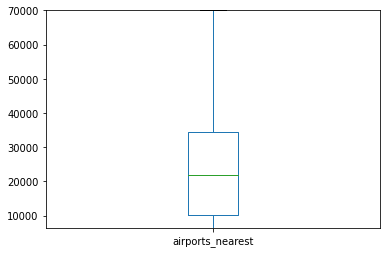

In [113]:
data['airports_nearest'].plot(kind='box', ylim=(6400,70000))

Text(0, 0.5, 'Количество квартир')

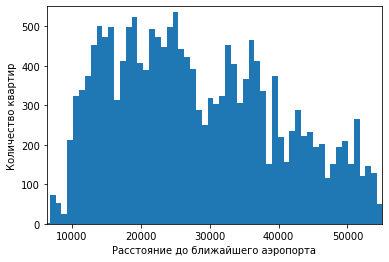

In [114]:
data['airports_nearest'].plot(kind='hist', xlim=(6400,55000) , ylim=(0,550), bins=100)
plt.xlabel('Расстояние до ближайшего аэропорта')
plt.ylabel('Количество квартир')

In [115]:
data.query("airports_nearest>50000")

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition,locality_name_e,price_one_meter,week_day,month,year,type_floor,city_centers_nearest_km
6,6,3700000,37.3,2017-11-02,1,2.65,26,10.600000,6,False,False,False,14.400000,1,посёлок парголово,52996,19143,0,0,0,0,155,парголово,99195.710456,3,11,2017,другой,19.0
9,18,5400000,61.0,2017-02-26,3,2.50,9,43.600000,7,False,False,False,6.500000,2,санкт-петербург,50898,15008,0,0,0,0,289,санкт-петербург,88524.590164,6,2,2017,другой,15.0
20,12,6120000,80.0,2017-09-28,3,2.70,27,48.000000,11,False,False,False,12.000000,2,посёлок парголово,53134,19311,0,0,0,0,74,парголово,76500.000000,3,9,2017,другой,19.0
40,9,3590000,36.0,2017-03-15,1,2.60,26,15.000000,22,False,False,False,10.000000,2,посёлок парголово,52996,19143,0,0,0,0,430,парголово,99722.222222,2,3,2017,другой,19.0
53,7,4300000,39.1,2017-11-10,1,2.65,25,15.400000,13,False,False,False,15.500000,2,посёлок парголово,52611,18783,0,0,0,0,6,парголово,109974.424552,4,11,2017,другой,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23613,4,3950000,52.0,2018-03-04,3,2.65,5,29.545455,2,False,False,False,8.961354,0,посёлок парголово,55549,21223,0,0,0,0,45,парголово,75961.538462,6,3,2018,другой,21.0
23615,6,3470000,31.0,2018-02-16,1,2.50,9,18.000000,5,False,False,False,6.300000,0,санкт-петербург,51544,16787,0,0,1,1032,38,санкт-петербург,111935.483871,4,2,2018,другой,17.0
23628,12,7400000,80.0,2017-01-20,3,2.65,12,48.000000,1,False,False,False,16.000000,0,санкт-петербург,50706,16034,0,0,0,0,23,санкт-петербург,92500.000000,4,1,2017,первый,16.0
23634,14,4100000,51.0,2017-08-18,1,2.65,18,17.500000,2,False,False,False,15.500000,1,посёлок парголово,61710,20866,0,0,0,0,409,парголово,80392.156863,4,8,2017,другой,21.0


Средний расстояние до  ближайшего аэропорта - 28 км. Медиана - 26 км. Три четверти всех квартир располагаются на расстоянии не более 37 км от аэропорта. Есть квартиры, которые расположены дальше 50 км - таких 1129 квартир.

#### Проанализируем расстояние до ближайшего парка

исключим из анализа расстояние до ближайшего парка =0, т.к. мы заполняли пропуски нулями.

In [116]:
data.query("parks_nearest > 1")['parks_nearest'].describe()

count    7966.000000
mean      491.128170
std       341.545822
min         3.000000
25%       288.000000
50%       455.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64

In [117]:
data.query("0 < parks_nearest < 10")

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition,locality_name_e,price_one_meter,week_day,month,year,type_floor,city_centers_nearest_km
2527,8,4690000,60.3,2016-03-05,2,2.50,5,28.000000,2,False,False,False,7.900000,0,кронштадт,69775,51500,3,9,3,345,146,кронштадт,77777.777778,5,3,2016,другой,52.0
9344,12,3000000,28.1,2017-07-25,1,2.50,9,17.000000,1,False,False,False,5.600000,0,санкт-петербург,12051,11665,1,7,1,780,440,санкт-петербург,106761.565836,1,7,2017,первый,12.0
11949,7,4500000,44.0,2017-11-24,2,2.60,9,30.000000,7,False,False,False,7.000000,0,санкт-петербург,11806,12292,1,3,1,508,82,санкт-петербург,102272.727273,4,11,2017,другой,12.0
14624,8,3770000,45.4,2019-03-20,2,2.65,9,28.430000,2,False,False,False,6.900000,0,санкт-петербург,43932,16436,1,1,0,0,42,санкт-петербург,83039.647577,2,3,2019,другой,16.0
20193,3,11809670,102.6,2017-04-21,3,2.65,9,58.295455,3,False,False,False,17.800000,2,санкт-петербург,27562,6410,2,9,2,480,90,санкт-петербург,115103.996101,4,4,2017,другой,6.0
22941,8,10965000,69.3,2019-01-10,1,3.00,4,48.900000,4,True,False,False,11.942728,2,зеленогорск,73391,54490,3,4,1,217,110,зеленогорск,158225.108225,3,1,2019,последний,54.0


<AxesSubplot: >

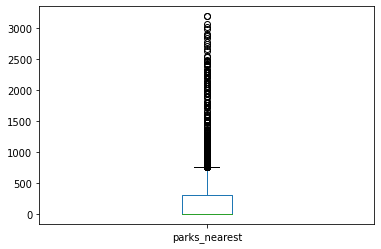

In [118]:
data['parks_nearest'].plot(kind='box')

Text(0, 0.5, 'Количество квартир')

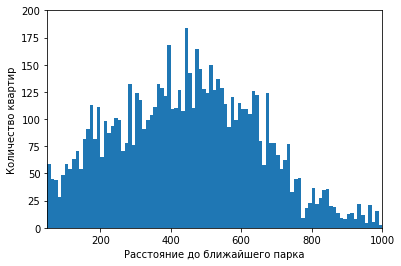

In [119]:
data['parks_nearest'].plot(kind='hist', xlim=(50,1000) , ylim=(0,200), bins=100, range=(0,1000))
plt.xlabel('Расстояние до ближайшего парка')
plt.ylabel('Количество квартир')

In [120]:
data.query("parks_nearest > 1000")

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition,locality_name_e,price_one_meter,week_day,month,year,type_floor,city_centers_nearest_km
195,8,5300000,60.0,2016-05-19,3,2.65,9,34.090909,4,False,False,False,10.340024,0,санкт-петербург,52072,17061,1,1133,3,239,372,санкт-петербург,88333.333333,3,5,2016,другой,17.0
196,7,8715960,57.0,2017-06-29,1,2.65,5,20.000000,5,False,False,False,16.000000,0,санкт-петербург,17462,16465,1,1205,2,97,119,санкт-петербург,152911.578947,3,6,2017,последний,16.0
232,14,3900000,42.2,2018-03-08,1,2.65,14,14.700000,4,False,False,False,10.400000,0,санкт-петербург,23239,12102,1,1021,1,893,166,санкт-петербург,92417.061611,3,3,2018,другой,12.0
323,6,9591727,72.0,2017-06-29,2,2.80,10,34.000000,9,False,False,False,17.000000,0,санкт-петербург,23756,5384,1,2295,1,534,118,санкт-петербург,133218.430556,3,6,2017,другой,5.0
371,11,7300000,65.0,2018-09-12,2,2.65,12,30.040000,2,False,False,False,10.200000,5,санкт-петербург,18621,17623,1,1510,2,372,92,санкт-петербург,112307.692308,2,9,2018,другой,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23404,3,17671500,90.0,2017-02-03,2,2.80,12,35.000000,9,False,False,False,16.000000,1,санкт-петербург,39946,10720,1,2102,3,303,277,санкт-петербург,196350.000000,4,2,2017,другой,11.0
23426,17,8778000,47.5,2014-12-29,1,3.00,7,26.988636,4,False,False,False,11.700000,2,санкт-петербург,39412,10186,1,1424,3,204,1360,санкт-петербург,184800.000000,0,12,2014,другой,10.0
23460,11,3800000,43.1,2016-04-21,2,2.65,5,27.600000,5,False,False,False,5.100000,0,санкт-петербург,40497,9756,1,1079,0,0,84,санкт-петербург,88167.053364,3,4,2016,последний,10.0
23466,15,11900000,80.0,2017-08-16,2,2.65,5,45.454545,3,False,False,False,13.786699,0,санкт-петербург,36813,8572,1,2467,3,214,116,санкт-петербург,148750.000000,2,8,2017,другой,9.0


Средний расстояние до ближайшего парка - 488 м. Медиана - 453 м. Три четверти всех квартир располагаются на расстоянии не более 610 м от парка. Есть квартиры, которые расположены дальше 1000 м - таких 328 квартир.

#### Пронализируем день и месяц публикации объявления

##### День недели

In [121]:
data.pivot_table(index='week_day', values='last_price', aggfunc='count').reset_index()

,week_day,last_price
0,0,3564
1,1,4128
2,2,3918
3,3,4243
4,4,3954
5,5,1898
6,6,1665


из распределния по дням видно, что наибольшее количество объявлени выложено в четверг, в выходные объявления выкладываются в 2 раза меньше

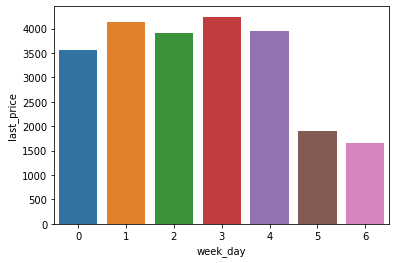

In [122]:
pivot_day = data.pivot_table(index='week_day', values='last_price', aggfunc='count').reset_index()
sns.barplot(data=pivot_day, x='week_day', y='last_price');

вот что выдается при попытке построить через **.plot**

по месяцам:

In [124]:
pivot_month = data.pivot_table(index='month', values='last_price', aggfunc='count').reset_index()

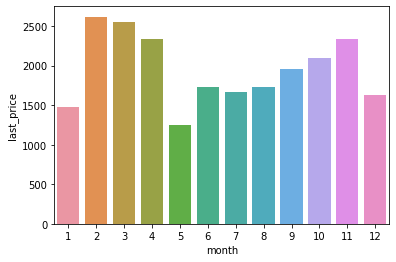

In [125]:
sns.barplot(data=pivot_month, x='month', y='last_price');

##### Месяц

In [126]:
data.pivot_table(index='month', values='last_price', aggfunc='count').reset_index().sort_values(by='last_price')

,month,last_price
4,5,1247
0,1,1478
11,12,1623
6,7,1668
7,8,1725
5,6,1733
8,9,1960
9,10,2091
3,4,2337
10,11,2340


Наибольшее количество объявлений выклыдвается в феврале-апреле и в ноябре. Меньше всего объявлений выкладывается в Мае, Январе и Декабре

#### Анализ срока продажи квартиры

In [127]:
data[data['days_exposition']>0]['days_exposition'].describe()

count    20220.000000
mean       181.118348
std        220.030801
min          1.000000
25%         45.000000
50%         96.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

Text(0, 0.5, 'Количество квартир')

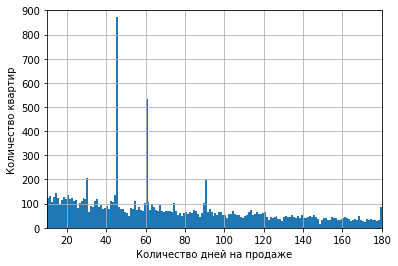

In [128]:
data[data['days_exposition']>0]['days_exposition'].plot(kind='hist', bins=180, xlim=(10,180) , ylim=(0,900), grid=True, range=(0,180))
plt.xlabel('Количество дней на продаже')
plt.ylabel('Количество квартир')

In [129]:
data[data['days_exposition']>400]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition,locality_name_e,price_one_meter,week_day,month,year,type_floor,city_centers_nearest_km
2,10,5196000,56.00,2015-08-20,2,2.65,5,34.300000,4,False,False,False,8.300000,0,санкт-петербург,21741,13933,1,90,2,574,558,санкт-петербург,92785.714286,3,8,2015,другой,14.0
3,0,64900000,159.00,2015-07-24,3,2.65,14,90.340909,9,False,False,False,27.401064,0,санкт-петербург,28098,6800,2,84,3,234,424,санкт-петербург,408176.100629,4,7,2015,другой,7.0
17,6,4180000,36.00,2016-09-09,1,2.65,17,16.500000,7,False,False,False,11.000000,1,санкт-петербург,33564,14616,0,0,1,859,571,санкт-петербург,116111.111111,4,9,2016,другой,15.0
23,11,2950000,32.00,2016-10-29,1,2.60,9,17.700000,9,False,False,False,6.100000,0,санкт-петербург,15414,14211,2,517,1,190,615,санкт-петербург,92187.500000,5,10,2016,последний,14.0
35,6,15500000,149.00,2017-06-26,5,2.65,5,104.000000,4,False,False,False,17.000000,0,санкт-петербург,23670,3502,0,0,1,779,644,санкт-петербург,104026.845638,0,6,2017,другой,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23672,5,3000000,30.80,2016-06-08,1,2.65,5,16.100000,3,False,False,False,6.300000,0,санкт-петербург,44614,14193,2,258,0,0,808,санкт-петербург,97402.597403,2,6,2016,другой,14.0
23675,8,3550000,39.50,2016-10-03,1,2.65,16,19.000000,13,False,False,False,8.500000,0,санкт-петербург,25740,14951,0,0,0,0,721,санкт-петербург,89873.417722,0,10,2016,другой,15.0
23691,11,9470000,72.90,2016-10-13,2,2.75,25,40.300000,7,False,False,False,10.600000,1,санкт-петербург,19424,4489,0,0,1,806,519,санкт-петербург,129903.978052,3,10,2016,другой,4.0
23692,2,1350000,30.00,2017-07-07,1,2.65,5,17.500000,4,False,False,False,6.000000,0,тихвин,0,0,0,0,0,0,413,тихвин,45000.000000,4,7,2017,другой,0.0


Средний срок продажи квартиры 185 дней - 6 месяцев. Медиана - 102 дня = 3,5 месяца.
Три четверти квартиры продаются в пределах 239 - 8 месяцев.
Есть квартиры, которые продаются более 400 дней - 2461 квартира.
Быстрыми можно считать продажи квартиры в первые 60 дней.
Долгие - более 6 месяцев

### Опререлим какие факторы больше всего влияют на общую (полную) стоимость объекта?

для определения зависимости цены квартиры от типа этажа введем численные обозначения: 0 -первый, 1 - другой, 2 - последний

In [130]:
data.loc[data['type_floor']=='первый','type_floors_index'] = 0

In [131]:
data.loc[data['type_floor']=='другой','type_floors_index'] = 1

In [132]:
data.loc[data['type_floor']=='последний','type_floors_index'] = 2

In [133]:
data['type_floors_index'].value_counts()

1.0    17203
2.0     3312
0.0     2855
Name: type_floors_index, dtype: int64

сделаем отдельную таблицу с интересуемыми нас стобцами для расчета корреляции:  
- нелинейными = площади
- остальными

In [134]:
data_corr_notline = data.pivot_table(index='last_price', values=['total_area', 'living_area', 'kitchen_area'], aggfunc='median').reset_index()
data_corr_other = data.pivot_table(index='last_price', values=['rooms', 'type_floors_index', 'week_day', 'month', 'year'], aggfunc='median').reset_index()

выведем таблицу с коэффициентами корреляции

In [135]:
data_corr_notline.corr()

,last_price,kitchen_area,living_area,total_area
last_price,1.000000,0.575554,0.642872,0.688744
kitchen_area,0.575554,1.000000,0.632009,0.729932
living_area,0.642872,0.632009,1.000000,0.963314
total_area,0.688744,0.729932,0.963314,1.000000


In [136]:
data_corr_other.corr()

,last_price,month,rooms,type_floors_index,week_day,year
last_price,1.000000,0.001798,0.440401,0.141637,0.027830,-0.089362
month,0.001798,1.000000,0.008360,-0.010737,0.045466,-0.270291
rooms,0.440401,0.008360,1.000000,0.100401,-0.019401,-0.090825
type_floors_index,0.141637,-0.010737,0.100401,1.000000,0.034501,-0.021547
week_day,0.027830,0.045466,-0.019401,0.034501,1.000000,-0.021186
year,-0.089362,-0.270291,-0.090825,-0.021547,-0.021186,1.000000


Цена квартиры имеет наибольшую зависимость от общей площади квартиры, жилой площади и площади кухни. Чуть мешьше завсимость от количества комнат. От остальных параметров зависимость минимальна или отсутствует.

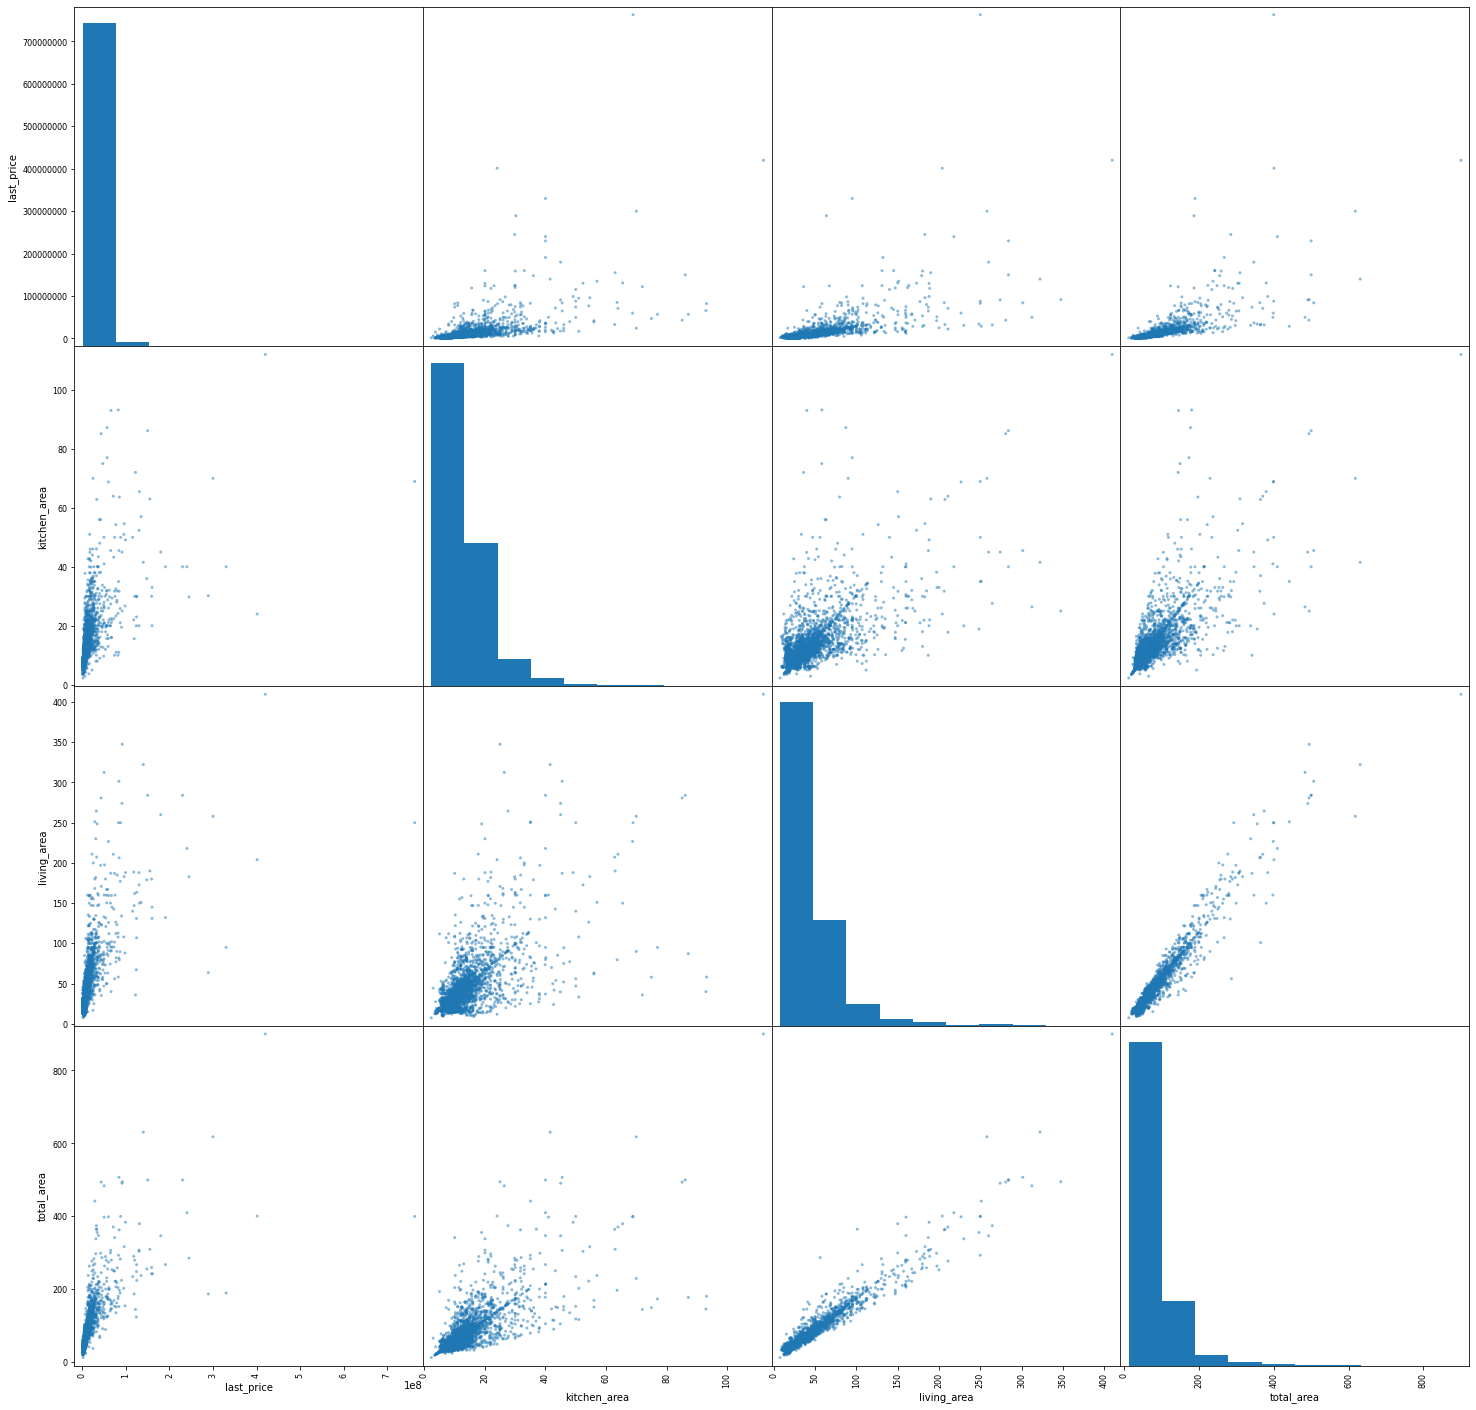

In [137]:
pd.plotting.scatter_matrix(data_corr_notline, figsize=(25, 25));

#### Построим зависимость медианной стоимости квартир по дням недели:

/opt/conda/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1041: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


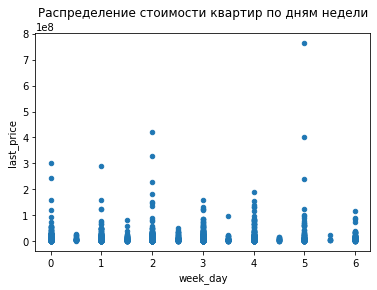

In [152]:
data_corr_other.sort_values('week_day').plot(x='week_day', y='last_price', kind = 'scatter');
plt.title('Распределение стоимости квартир по дням недели');

в объявлениях, размещенных в субботу цена в 2 раза выше. в четверг и воскресенье - самая низкая.

#### Построим зависимость медианной стоимости квартир по месяцам:

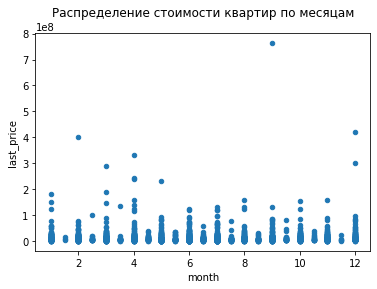

In [153]:
data_corr_other.sort_values('month').plot(x='month', y='last_price', kind = 'scatter');
plt.title('Распределение стоимости квартир по месяцам');

в объявлениях, размещенных в сентябре цена в среднем в 2 раза выше. В феврале и декабре тоже цена выше, чем в сравнении с другими месяцами

#### Построим зависимость медианной стоимости квартир по годам:

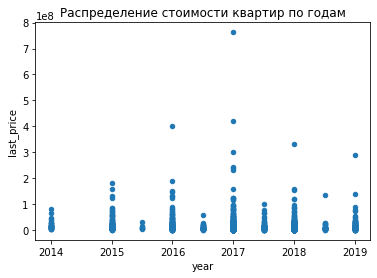

In [154]:
data_corr_other.sort_values('year').plot(x='year', y='last_price', kind = 'scatter');
plt.title('Распределение стоимости квартир по годам');

в объявлениях, размещенных в 2017 году цена в среднем в 2 раза выше

#### Построим зависимость медианной стоимости квартир в зависимости от количества комнат:

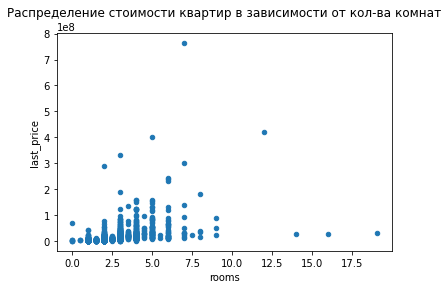

In [155]:
data_corr_other.sort_values('rooms').plot(x='rooms', y='last_price', kind = 'scatter');
plt.title('Распределение стоимости квартир в зависимости от кол-ва комнат');

Самые дорогие квартиры имеют 7 комнат

#### Построим зависимость медианной стоимости квартир в зависимости от типа этажа:

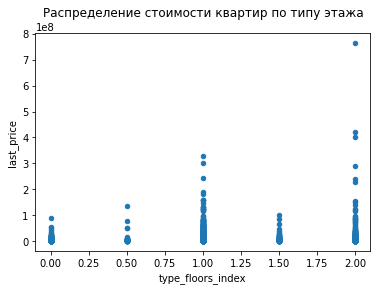

In [156]:
data_corr_other.sort_values('type_floors_index').plot(x='type_floors_index', y='last_price', kind = 'scatter');
plt.title('Распределение стоимости квартир по типу этажа');

Самые дорогие квартиры находятся на последнем этаже. Странно, но обычно квартиры на последнем этаже не хотят покупать..

### Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений

In [143]:
ten_biggest_city = data.pivot_table(index='locality_name_e', values=['last_price', 'price_one_meter'] , aggfunc={'last_price':'count', 'price_one_meter':'median'}).reset_index().sort_values(by='last_price', ascending=False)
ten_biggest_city = ten_biggest_city[0:10]
ten_biggest_city

,locality_name_e,last_price,price_one_meter
219,санкт-петербург,15527,104651.162791
146,мурино,573,86075.949367
108,кудрово,465,95522.388060
304,шушары,438,76747.967480
35,всеволожск,390,65737.874097
199,пушкин,368,100000.000000
90,колпино,337,74725.274725
170,парголово,326,91579.708641
43,гатчина,303,67647.058824
36,выборг,234,58357.385977


In [144]:
display(ten_biggest_city[ten_biggest_city['price_one_meter'] == ten_biggest_city['price_one_meter'].min()])
display(ten_biggest_city[ten_biggest_city['price_one_meter'] == ten_biggest_city['price_one_meter'].max()])

,locality_name_e,last_price,price_one_meter
36,выборг,234,58357.385977


,locality_name_e,last_price,price_one_meter
219,санкт-петербург,15527,104651.162791


дешевле всего квадратный метр стоит в Выборге. Дороже всего - в Санкт-Петербурге

### Вычислим среднюю цену каждого километра в Санкт-Петербурге

In [145]:
data_spb = data[data['locality_name_e'] == 'санкт-петербург']


In [146]:
(
data_spb.pivot_table(
    index='city_centers_nearest_km', 
    values='last_price', 
    aggfunc='mean')
    .reset_index()
    .sort_values(by='city_centers_nearest_km')
)

,city_centers_nearest_km,last_price
0,0.0,2.027726e+07
1,1.0,2.114334e+07
2,2.0,1.789211e+07
3,3.0,1.116109e+07
4,4.0,1.329116e+07
5,5.0,1.449038e+07
6,6.0,1.504822e+07
7,7.0,1.482078e+07
8,8.0,9.946146e+06
9,9.0,6.954153e+06


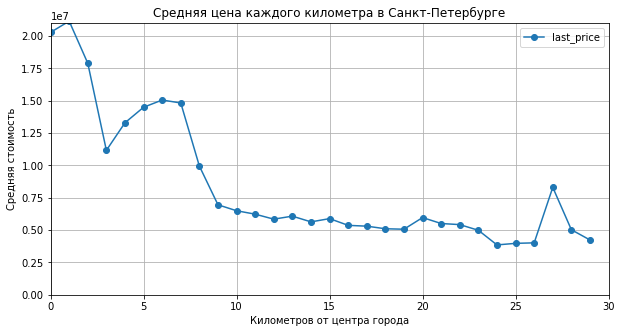

In [147]:
(
data_spb.pivot_table(
    index='city_centers_nearest_km', 
    values='last_price', 
    aggfunc='mean')
    .reset_index()
    .sort_values(by='city_centers_nearest_km')
    .plot(x='city_centers_nearest_km',
    y='last_price', 
    style='o-', 
    xlim=(0, 30),
    ylim=(0, 21000000), 
    figsize=(10, 5), 
    grid=True) 
)
plt.title('Средняя цена каждого километра в Санкт-Петербурге')
plt.xlabel('Километров от центра города')
plt.ylabel('Средняя стоимость')
plt.show()

посмотрим какой населенный пункт на расстоянии 27 км является "элитным"

In [148]:
data[data['city_centers_nearest_km']==27].groupby('locality_name_e')['last_price'].agg(['count','mean'])

,count,mean
locality_name_e,,
александровская,1,3.750000e+06
красное село,1,3.000000e+06
металлострой,31,3.702839e+06
петро-славянка,1,1.980000e+06
пушкин,68,7.033950e+06
санкт-петербург,2,8.300000e+06


Стоимость квартиры напрямую зависит от близости к центру города.  
Есть "провал" цены при расстоянии 3 км от центра города, далее идет небольшой рост цены на расстоянии от 4 до 6 км от центра и потом плавное падение.  
В зоне 20 км от центра города средняя цена выростает на 1 млн, а в зоне 27 км она резко увеличивает цену в 2 раза по сравнению с "соседями". "Элитным" является "Пушкин".

### Общий вывод

В ходе выполнения проекта я моей задачей было понять от чего зависит стоимость квартиры, посмотреть в каких городах наибольшее количество объявлений и есть ли зависимость стоимости квартиры от удаленности от центра города.  

На первом этапе я познакомился с данными, посмотрел типы и количество данных, определил в каких столбцах есть пропущенные значения.  
Привел столбцы к «правильному» названию.  

#### На этапе предобработки данных я более подробно проанализировал каждый параметр.  
У количественных показателей проанализировал основные статистические метрики, посмотрел пропуски, выбросы и аномальные значения.  


Пропуски в некоторых параметрах (**высота потолков**, **жилая площадь**, **площадь кухни**)   заполнял медианой.  
В некоторых (**всего этажей в доме**) - удалил строки с пропусками.  
А в некоторых случаях (**апартаменты** и **количество балконов**) заполнял нулями, т.к. вероятнее всего данные пропуски означают «нет».  


Разобрался с типами данных: 
Цену квартиры, всего этажей, количество балкнонов, ближайший аэропорт, расстояние до центра города, количество парков и прудов на расстоянии до 3км, количество таких парков и прудов и количество дней размещения объявления привел из **дробного** в **целый** тип,
Дату размещения перевели в тип **DataTime**
Апартаменты в **BOOL**
Проверил наличие явных дубликатов и проработал неявные дубликаты в стролбце с **названием населенного пункта**.
Сначала привел названия населенных пунктов к нижнему регистру, затем заменил ё на е, а потом выделил из названия населенного пункта только само название.
Таким образом вместо **365** наименований населенных пунктов сталось **311**.
Дополнительная аналитика: **66% объявлений** размещено в Санкт-Петербурге. Далее населенные пункты имеют не более **2% от общей доли** объявлений.


#### В датафрейм добавлил новые столбцы: 
•	Цена за 1 квадратный метр;  
•	День, месяц и год публикации объявления;  
•	Тип этажа (первый, последний или другой);  
•	Расстояние от центра города в километрах.  

#### На этапе исследовательского анализа данных я более детально углубился 
**Основные выводы:**  

**Общая площадь:** максимальное количество объектов имеют площадь 45 кв м. Среднее значение общей площади квартиры 60 кв метров. Медиана - 52 кв метра. Три четверти всех квартир имеют площадь до 69 кв.м. Есть выбросы - квартиры с площадью больше 300 кв.м. - 61 квартира.

**Жилая площадь:** Максимальное количетсво квартир имеют площадь 20 метров. Среднее значение жилой площади квартиры 34 кв метров. Медиана - 30 кв метра. Три четверти всех квартир имеют жилую площадь до 42 кв.м. Есть выбросы - квартиры с жилой площадью больше 100 кв.м. - 385 квартир С жилой площадью меньше 10 кв м - 17 квартир.  

**Площадь кухни:**   Максимальное количество квартир имеют площадь кухни от 6 до 12 кв метров.  Среднее значение площади кухни 10,4 кв метров. Медиана - 9 кв метра. Три четверти всех квартир имеют жилую площадь до 11,9 кв.м. Есть выбросы - квартиры с площадью кухни больше 50 кв.м. - 48 квартир. С  площадью кухни менее 4 кв м - 79 квартир.  

**Цена квартиры:** Наибольшее количество квартир стоят 3,5-5 млн рублей.  Среднее стоимость квартиры 6,4 млн рублей. Медиана - 4,6 млн. Три четверти всех квартир  имеют стоимость до 6,7 млн рублей. Есть выбросы - квартиры стоимостью больше 20 млн 602 квартиры. Стоимостью менее 1 млн - 176 квартир.  

**Количество комнат:** Наибольшее количество объявлений имеют 1 или 2 комнаты.  
Среднее количество комнат равно 2. Медиана тоже равна 2. Три четверти всех квартир  имеют 3 комнаты. Есть выбросы - квартиры с более чем 5 комнатами - 179 квартиры.  

**Этаж, на котором расположена квартира:** Наибольшее количество квартир располножены на 2-3 этажах
Средний этаж - 6. Медиана - 4. Три четверти всех квартир располагаются с 1 по 8 этаж. Есть квартиры, которые расположены выше 20 этажа - таких 428 квартир.  

**Количество этажей в доме:** Средний количество этажей - 10. Медиана - 9. Всплески видны на 5, 9, 12, 16 и 25 этажных домах. Не удивительно, большинство домов 5ти и 9ти этажные.  

**Удаленность квартиры от центра города:** Наибольшее количество квартир располагаются на расстоянии 12 и 15 км от центра города.  
Средний расстояние до центра города - 14,2 км. Медиана - 13,1 км. Три четверти всех квартир располагаются  на расстоянии не более 16 км. Есть квартиры, которые расположены дальше 20 км - таких 2421 квартира. 

**День недели , в который выложено объявление:** из распределния по дням видно, что наибольшее количество объявлени выложено в четверг, в выходные объявления выкладываются в 2 раза меньше.  

**Месяц, в котором выложено объявление:** Наибольшее количество объявлений выкладывается в феврале-апреле и в ноябре. Меньше всего объявлений выкладывается в Мае, Январе и Декабре.  

**Срок продажи объявления:** Средний срок продажи квартиры 185 дней - 6 месяцев. Медиана - 102 дня = 3,5 месяца. Три четверти квартиры продаются в пределах 239 - 8 месяцев. Есть квартиры, которые продаются более 400 дней - 2461 квартира. Быстрыми можно считать продажи квартиры в первые 60 дней. Долгие - более 6 месяцев.  
Большинство квартир продаются на 45 и 60 день размещения объявления – понять так ли это или заканчивается срок размещения возможности нет.

#### В результате анализа зависимости цены квартиры от других параметров
Выяснил, что цена квартиры имеет наибольшую зависимость от общей площади квартиры, жилой площади и площади кухни. Чуть меньше зависимость от количества комнат. От остальных параметров зависимость минимальна или отсутствует.  
**Дополнительные наблюдения:**  
•	в объявлениях, размещенных в **субботу** цена в 2 раза выше. в четверг и воскресенье - самая низкая;  
•	в объявлениях, размещенных в **сентябре** цена в среднем в 2 раза выше. В **феврале и декабре** тоже цена выше, чем в сравнении с другими месяцами;  
•	в объявлениях, размещенных в **2017** году цена в среднем в 2 раза выше;  
•	Самые дорогие квартиры имеют **7 комнат**;  
•	Самые дорогие квартиры находятся на **последнем этаже**. Странно, но обычно квартиры на последнем этаже не хотят покупать.

#### В результате анализа средней цены одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений  
Выяснил, что самые дорогие квартиры в Санкт-Петербуре - средняя стоимость 1 кв. м. жилья составляет 104 тыс рублей.  
Самые дешевые квартиры в Выборге - 58 тыс рублей за 1 кв.м.  

#### В результате анализа средней цены каждого километра в Санкт-Петербурге
Выяснил, что стоимость квартиры напрямую зависит от близости к центру города.  
Есть "провал" цены при расстоянии 3 км от центра города, далее идет небольшой рост цены на расстоянии от 4 до 6 км от центра и потом плавное падение.  
В зоне 20 км от центра города средняя цена вырастает на 1 млн, а в зоне 27 км она резко увеличивает цену в 2 раза по сравнению с "соседями". **"Элитным"** является **"Пушкин"**.
